<a href="https://colab.research.google.com/github/adammuhtar/uk_econ_strategies_text_mining_network_analysis/blob/main/UK_Economic_Strategy_Text_and_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Textual and network analysis of UK's economic strategy policy adoption among ministerial departments and agencies**
---
This notebook contains Python scripts used to extract and analyse texts from policy papers published by the UK government from March 2021 to July 2022 to identify the extent of UK's economic policy rollout. This work builds from [Coyle & Muhtar (2021)](https://www.bennettinstitute.cam.ac.uk/publications/industrial-policy-learning-past/), which analyse the extent of policy co-ordination and consistency among institutions responsible for policy crafting and delivery of industrial support measures in the UK (also often referred to as industrial policy). In particular, this notebook contains code to run text mining analysis on the take-up of policies announced under the 2021 [Plan for Growth](https://www.gov.uk/government/publications/build-back-better-our-plan-for-growth) and the 2021 [UK Innovation Strategy](https://www.gov.uk/government/publications/uk-innovation-strategy-leading-the-future-by-creating-it) among all publicly available UK Government policy papers (available from https://www.gov.uk/search/policy-papers-and-consultations)

The paper containing the full analysis is forthcoming at: Coyle, D. & Muhtar, A. (2022) "You’re not speaking my language: policy discontinuity and coordination gaps between the UK’s national economic strategies and its place-based policies."

## **Notes on Google Colab**
This text analysis of industrial policy uptake within the UK's government policy papers uses Google Colaboratory (**Colabs**) to run this Python script. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/) and like all Jupyter Notebooks, a Colab consists of two kinds of components:

  * **Text cells**, which contain explanations. This cell, for instance, is a text cell.
  * **Code cells**, which contain Python code for the user to run. Code cells have a light gray/black background (depending on the mode being run.

Text cells are to be *read* and code cells are to be *executed*.

#### **Running code cells**

If viewed using Google Colab, execution of code cells must run in order. In other words, the user may only run a code cell once all the code cells preceding it have already been run.

To run a code cell:

  1. Place the cursor anywhere inside the [ ] area at the top left of a code cell. The area inside the [ ] will display an arrow.
  2. Click the arrow.

Alternatively, the user may invoke **Runtime → Run all**.

For ease of reading, please navigate this notebook using the table of contents (if viewed using Google Colab, this is accessible via the three-dots-and-bars icon on the left-hand side).

## **Setting up Google Colab notebook**
---
We first set up our Colab notebook by installing/updating text mining library [`pdfplumber`](https://pypi.org/project/pdfplumber/) into the local Colab environment.

In [ ]:
#@title Install latest version of text extraction/conversion and image exporting packages
# Refer to https://github.com/jsvine/pdfplumber for documentation
!pip install --upgrade pypandoc
!pip install --upgrade pdfplumber

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 17.9 MB/s 
     |████████████████████████████████| 139 kB 41.3 MB/s 
     |████████████████████████████████| 3.1 MB 29.9 MB/s 
     |████████████████████████████████| 4.1 MB 41.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## **Web scraping HTML and PDF documents, text extraction, and text pre-processing UK Government policy papers**
---
This section details the text mining operations conducted in order to analyse the policy papers; these include codes that runs web scraping, text extraction and conversion to plain text, word tokenisation, and stop word removal processes. The policy papers themselves are sourced from the UK Government document search webpage, available [here](https://www.gov.uk/search/policy-papers-and-consultations) by filtering for policy papers published or updated from 3 March 2021 onwards (the publication date of the Plan for Growth).

*N.B.: Some policy papers (e.g. [Tackling violence against women and girls strategy: British Sign Language version](https://www.gov.uk/government/publications/tackling-violence-against-women-and-girls-strategy-british-sign-language-version)) do not have HTML or PDF documents.*

In [ ]:
#@title Create a directory to house all downloaded documents
import os                           # interacting with the operating system


# Create a new directory "speeches"
doc_dir = "/content/documents"    # file path should be changed accordingly
os.mkdir(doc_dir)

In [ ]:
#@title Change working directory
%cd documents

/content/documents


In [ ]:
#@title Web scraping policy papers home pages from GOV.UK
#@markdown *Last execution speed: 2m 25s*
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import time
start_time = time.time()


# List of GOV.UK policy papers queried search pages
# Check search listing at https://www.gov.uk/search/policy-papers-and-consultations and update page range
url_pt1 = "https://www.gov.uk/search/policy-papers-and-consultations?content_store_document_type%5B%5D=policy_papers&order=updated-oldest&page="
url_pt2 = "&public_timestamp%5Bfrom%5D=3%2F3%2F2021"
search_urls = [url_pt1 + str(x) + url_pt2 for x in range(1, 109)]


# Extracting URLs from GOV.UK policy papers search pages
paths = []
for url in search_urls:
    soup = BeautifulSoup(urlopen(Request(url)), "lxml")
    for path in soup.findAll("a"):
        paths.append(path.get("href"))

paths = [path for path in paths if "/government/publications/" in path]
paths = [path for path in paths if "/build-back-better-our-plan-for-growth" not in path and "/uk-innovation-strategy-leading-the-future-by-creating-it" not in path]


# Removing duplicate paths from GOV.UK policy papers search pages URL extraction
paths_check = paths.copy()
paths_duplicate = []

for path in paths:
    for i in range(0, len(paths_check)):
        if path + "/" in paths_check[i]:
            paths_duplicate.append(paths_check[i])

paths_clean = [path for path in paths if path not in paths_duplicate]
doc_urls = ["https://www.gov.uk" + path for path in paths_clean]
print("Unique URLs available:", len(doc_urls), sep = " ")


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Unique URLs available: 2158
Execution time: 00:02:25


In [ ]:
#@title Unique URLs available
len(doc_urls)

2158

In [ ]:
#@title Web scraping policy paper document URL from home pages
#@markdown *Last execution speed: 5m 44s*
import pandas as pd             # data processing, CSV file I/O
start_time = time.time()


doc_paths = []
doc_org = []

for url in doc_urls:
    temp_href = []
    temp_path = []
    temp_org = []
    # HTML parser using BeautifulSoup
    soup = BeautifulSoup(urlopen(Request(url)), "lxml")
    for path in soup.findAll("a"):
        temp_href.append(path.get("href"))
    # Select the first instance of HTML/PDF href attribute
    for i in range(0, len(temp_href)):
        if url == "https://www.gov.uk/government/publications/levelling-up-the-united-kingdom":
            temp_path.append(
                "https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1054769/Levelling_Up_the_United_Kingdom__accessible_version_.pdf"
            )
            break
        elif url == "https://www.gov.uk/government/publications/declaration-on-government-reform":
            temp_path.append(
                "/government/publications/declaration-on-government-reform/declaration-on-government-reform"
            )
            break
        elif any(
            x in temp_href[i] for x in [
                                        "/government/publications/",
                                        "https://assets.publishing.service.gov.uk/"
            ]
        ):
            temp_path.append(temp_href[i])
            break
    # Append HTML directories with GOV.UK URL; append to doc_paths
    if temp_path != []:
        if "/government/publications/" in temp_path[0]:
            temp_path[0] = "https://www.gov.uk" + temp_path[0]
            doc_paths.append(temp_path[0])
            # Select the first instance of organisation href attribute
            for i in range(0, len(temp_href)):
                if any(x in temp_href[i] for x in ["/government/organisations/"]):
                    temp_org.append(temp_href[i])
                    break
            if temp_org != []:
                temp_org[0] = temp_org[0].replace("/government/organisations/", "")
                doc_org.append(temp_org[0])
            else:
                pass
        else:
            doc_paths.append(temp_path[0])
            # Select the first instance of organisation href attribute
            for i in range(0, len(temp_href)):
                if any(x in temp_href[i] for x in ["/government/organisations/"]):
                    temp_org.append(temp_href[i])
                    break
            if temp_org != []:
                temp_org[0] = temp_org[0].replace("/government/organisations/", "")
                doc_org.append(temp_org[0])
            else:
                pass
    else:
        pass

# List all unique values for government organisations
# list(set(doc_org))

# Zip URL and organisation lists into pandas dataframe
doc_df = pd.DataFrame(list(zip(doc_paths, doc_org)), columns = ["url", "org"])

# Remove ODT, TXT, XSLX, DOCX, XLSM files
# doc_df = doc_df[doc_df["url"].str.contains(".odt") == False]
# doc_df = doc_df[doc_df["url"].str.contains(".txt") == False]
# doc_df = doc_df[doc_df["url"].str.contains(".xlsx") == False]
# doc_df = doc_df[doc_df["url"].str.contains(".docx") == False]
# doc_df = doc_df[doc_df["url"].str.contains(".xlsm") == False]


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:05:44


In [ ]:
#@title Text extraction and pre-processing for HTML documents
#@markdown *Last execution speed: 3m*
from urllib.request import urlopen
from bs4 import BeautifulSoup   # data extraction from HTML/XML files
import re                       # regular expression operations
import string                   # string formatting functions
import unicodedata              # unicode normalisation
start_time = time.time()


# Create list of HTML document URLs
html_urls = []
html_texts = []

for url in doc_paths:
    if "https://www.gov.uk/government/publications/" in url:
        html_urls.append(url)

for i in range(0, len(html_urls)):
    if "https://www.gov.ukhttps://www.gov.uk/government/publications/" in html_urls[i]:
        html_urls[i] = re.sub(r".", "", html_urls[i], count = 18)


# Text extraction of HTML documents
for url in html_urls:
    temp_text = ""
    html = urlopen(url).read()
    html_parsed = BeautifulSoup(html, features = "html.parser")
    for text in html_parsed.find_all("h2"):
        temp_text += text.get_text()
    for text in html_parsed.find_all("p"):
        temp_text += text.get_text()
    # translating unicode strings into normal characters
    temp_text = unicodedata.normalize("NFKD", temp_text)
    # convert string to lowercases
    temp_text = temp_text.lower()
    # remove all punctuation symbols, except for "&()-."
    temp_text = temp_text.translate(
        str.maketrans(
            "", "", string.punctuation[:5] + string.punctuation[6] + string.punctuation[9:12] + string.punctuation[14:]
        )
    )
    # replace newline character with white space
    temp_text = temp_text.replace("\n", " ")
    # remove excess whitespaces
    temp_text = re.sub(" +", " ", temp_text)
    html_texts.append(temp_text)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:03:00


In [ ]:
#@title PDF scrapping from policy paper URLs
#@markdown *Last execution speed: 4m 23s*
import requests                 # make HTTP/1.1 requests
start_time = time.time()


# Download all files from URLs starting with "https://assets.publishing.service.gov.uk/ 
for url in doc_paths:
    if "https://assets.publishing.service.gov.uk/" in url:
        response = requests.get(url)
        if response.status_code == 200:
            file_path = os.path.join(doc_dir, os.path.basename(url))
            with open(file_path, "wb") as f:
                f.write(response.content)
    else:
        pass


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:04:23


In [ ]:
#@title Text extraction from PDFs
#@markdown *Last execution speed: 4h 3m 3s*
import pdfplumber               # PDF text extraction
start_time = time.time()


# Create a list of PDF file names and text file names
pdf_list = sorted(os.listdir(doc_dir))
pdf_list = [i for i in pdf_list if ".odt" not in i]
pdf_list = [i for i in pdf_list if ".ods" not in i]
pdf_list = [i for i in pdf_list if ".txt" not in i]
pdf_list = [i for i in pdf_list if ".xlsx" not in i]
pdf_list = [i for i in pdf_list if ".docx" not in i]
pdf_list = [i for i in pdf_list if ".xlsm" not in i]
txt_list = [pdf[:-4] + ".txt" for pdf in pdf_list]


# Extracting text and saving output in dictionary
for i in range(0, len(pdf_list)):
    out = open(txt_list[i], "wt")  # open text output
    with pdfplumber.open(os.fsdecode(pdf_list[i])) as pdf:
        for pdf_page in pdf.pages:
            page_text = pdf_page.extract_text()
            out.write(page_text)
        out.close()


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This could result in (cid) values in the output. The start and end byte have different lengths.
Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This could result in (cid) values in the output. The start and end byte have different lengths.
Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This could result in (cid) values in the output. The start and end byte have different lengths.
Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This could result in (cid) values in the output. The start and end byte have different lengths.
Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This could result in (cid) values in the output. The start and end byte have different lengths.
Ignoring (part of) ToUnicode map because the PDF data does not conform to the format. This

Execution time: 04:15:50


In [ ]:
#@title Text extraction for Microsoft Word documents
#@markdown *Last execution speed: 2s*
import pypandoc                 # document converter
start_time = time.time()

for doc in os.listdir(doc_dir):
    if doc[-5:] == ".docx":
        pypandoc.convert_file(doc, "plain", outputfile = doc[:-5] + ".txt")


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:00:03


In [ ]:
#@title Pre-processing text extracted from PDFs/Microsoft Word and matching to originating institutions
#@markdown *Last execution speed: 4m 22s*
start_time = time.time()


# Pre-processing TXT files within pandas dataframe
# Removing documents with unextractable texts (e.g. general vesting declarations, UNCRC Bills, etc.)
doc_df["text"] = ""
txt_to_str = [x for x in os.listdir(doc_dir) if ".txt" in x]
gvd_doc = [x for x in txt_to_str if "GVD_" in x]
unextractable_text = [
                      "Withdrawal_Agreement_Joint_Committee_Annual_Report_2020.txt",
                      "UNCRC_-_ECLSG_References_-_Written_Case_for_the_Attorney_General_and_Advocate_General_for_Scotland__1_.txt",
                      "211013_Signed_S50_Direction_-_Island_Project_School.txt",
                      "hs2_gvd_deed_and_plan_48.txt",
                      "hs2_gvd_deed_and_plan_39.txt",
                      "S221_007_01___GVD_16_and_Plan_16_-_certified_copy.txt",
                      "M162.txt", "dhsc-em-march-7-2022.txt",
                      "A1_Development_of_the_Proposed_Scheme_v1.txt",
                      "DVLA_Framework_Agreement.txt",
                      "Decision_No_2_2022_Withdrawal_Agreement_Joint_Committee_-_Amendment_to_Decision_No_7_2020.txt",
                      "FINAL_Declaration_on_Government_Reform.txt",
                      "A1_Development_of_the_Proposed_Scheme_v2.txt"
]
unextractable_text.extend(gvd_doc)
temp_text = ""

for i in range(0, len(doc_df["url"])):
    for j in range(0, len(txt_to_str)):
        if any(x in txt_to_str[j] for x in unextractable_text):
            pass
        elif txt_to_str[j][:-4] in doc_df["url"][i]:
            del temp_text
            temp_text = pd.read_csv(txt_to_str[j], delimiter = "\n", names = ["text"])
            # concatenate all rows into one row
            temp_text["text"] = temp_text["text"].str.cat(sep = " ")
            # dataframe now redundant, replace it with one of the rows 
            temp_text = temp_text["text"][0]
            # convert string to lowercases
            temp_text = temp_text.lower()
            # translating unicode strings into normal characters
            temp_text = unicodedata.normalize("NFKD", temp_text)
            # remove all punctuation symbols, except for "&()-."
            temp_text = temp_text.translate(
                str.maketrans(
                    "", "", string.punctuation[:5] + string.punctuation[6] + string.punctuation[9:12] + string.punctuation[14:]
                )
            )
            # remove excess whitespaces
            temp_text = re.sub(" +", " ", temp_text)
            doc_df["text"][i] = temp_text


# Match texts extracted from HTML docs to relevant originating institution
for i in range(0, len(doc_df["url"])):
    for j in range(0, len(html_urls)):
        if doc_df["url"][i] == html_urls[j]:
            doc_df["text"][i] = html_texts[j]


# Dropping URLs with unextractable texts
doc_df = doc_df[doc_df.text != ""]
doc_df.reset_index(drop = True, inplace = True)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:04:22


In [ ]:
#@title Export extracted texts as JSON file (preserve text mining work to date)
doc_df.to_json('/content/UK_govt_policy_papers.json')

In [ ]:
#@title Reading JSON file as pandas dataframe
import pandas as pd             # data processing, CSV file I/O

doc_df = pd.read_json('/content/UK_govt_policy_papers.json')
doc_df.describe()

,url,org,text
count,2012,2012,2012
unique,2011,85,1903
top,https://www.gov.uk/government/publications/cli...,high-speed-two-limited,in parliament – session 2021 - 2022 high speed...
freq,2,444,11


In [ ]:
#@title Remove dashes in ministerial department/government agency names
for i in range(0, len(doc_df)):
    doc_df["org"][i] = doc_df["org"][i].replace("-", " ")

doc_df.tail()

,url,org,text
2007,https://www.gov.uk/government/publications/fre...,foreign commonwealth development office,cookies on gov.uk navigation menu contents pre...
2008,https://www.gov.uk/government/publications/fre...,foreign commonwealth development office,cookies on gov.uk navigation menu contents pre...
2009,https://www.gov.uk/government/publications/fre...,foreign commonwealth development office,cookies on gov.uk navigation menu contents pre...
2010,https://www.gov.uk/government/publications/fre...,foreign commonwealth development office,cookies on gov.uk navigation menu contents pre...
2011,https://www.gov.uk/government/publications/fre...,foreign commonwealth development office,cookies on gov.uk navigation menu contents pre...


In [ ]:
#@title Ministries list
ministries_list = ["cabinet office",
                   "department for business energy and industrial strategy",
                   "department for digital culture media sport",
                   "department for education",
                   "department for environment food rural affairs",
                   "department for international trade",
                   "department for levelling up housing and communities",
                   "department for transport", "department for work pensions",
                   "department of health and social care",
                   "foreign commonwealth development office", "hm treasury",
                   "home office", "ministry of defence", "ministry of justice",
                   "northern ireland office",
                   "office of the secretary of state for scotland",
                   "office of the secretary of state for wales",
                   "prime ministers office 10 downing street",
                   "uk export finance"
]

In [ ]:
#@title Total policy papers mined from GOV.UK, by organisation
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go


# Create dataframe with policy papers count by organisation
total_mined = doc_df.org.value_counts().to_frame()
# Combine FCO with FCDO, MHCLG with DLUHC
total_mined.loc["foreign commonwealth development office"] = total_mined.loc["foreign commonwealth development office"] + total_mined.loc["foreign commonwealth office"]
total_mined.loc["department for levelling up housing and communities"] = total_mined.loc["department for levelling up housing and communities"] + total_mined.loc["ministry of housing communities and local government"]
total_mined.drop(
    [
     "ministry of housing communities and local government",
     "foreign commonwealth office"
    ],
    axis = "index", inplace = True
)
# Sort in descending order
total_mined.sort_values("org", ascending = False, inplace = True)
# Create ministry categorisation
total_mined["type"] = ""
for i in range(0, len(total_mined)):
    if any(x in total_mined.index[i] for x in ministries_list):
        total_mined["type"][i] = "Ministry"
    else:
        total_mined["type"][i] = "Non-ministry"


# Set plotly theme
pio.templates.default = "plotly_white"
# Create figure object
fig = px.bar(
    total_mined[total_mined["type"] == "Non-ministry"], y = "org", text_auto = "s",
    color_discrete_sequence = ["#85B09A"] * len(total_mined[total_mined["type"] == "Non-ministry"])
)
fig.update_traces(
    textfont_size = 12, textangle = -90, textposition = "outside",
    cliponaxis = False
)
fig.update_layout(
    yaxis = {
        "title": "Papers mined"
    },
    xaxis = {
        "title": ""
    },
    bargap = 0.05, showlegend = False, xaxis_tickangle = -90,
    width = 1400, height = 800
)
fig.show()

fig = px.bar(
    total_mined[total_mined["type"] == "Ministry"], y = "org", text_auto = "s",
    color_discrete_sequence = ["#037761"] * len(total_mined[total_mined["type"] == "Ministry"])
)
fig.update_traces(
    textfont_size = 12, textangle = -90, textposition = "outside",
    cliponaxis = False
)
fig.update_layout(
    yaxis = {
        "title": "Papers mined",
        "side": "right"
    },
    xaxis = {
        "title": ""
    },
    bargap = 0.05, showlegend = False, xaxis_tickangle = -90,
    width = 600, height = 800
)
fig.update_yaxes(range = [0, 450])
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title Horizontal bar chart of policy papers mined by organisation
import plotly.express as px
import plotly.io as pio
import kaleido

total_mined = doc_df.org.value_counts().to_frame()

# Set plotly theme
pio.templates.default = "plotly_white"

fig = px.bar(
    total_mined, x = "org", orientation = "h",
    text_auto = "s", color_discrete_sequence = ["#037761"] * len(total_mined)
)
fig.update_traces(
    textfont_size = 12, textangle = 0, textposition = "outside",
    cliponaxis = False
)
fig.update_layout(
    yaxis = {
        "title": "",
        "autorange": "reversed"
    },
    xaxis = {
        "title": "Papers mined",
        "side": "top"
    },
    bargap = 0.05,
    width = 800, height = 1400
)
fig.show()
#save a figure of 300dpi, with 2.5 inches, and height 5 inches
# pio.write_image(
#     fig, "/content/mined_papers.jpg", format = "jpeg", scale = 1,
#     width = 800, height = 1400, engine = "kaleido"
# )

## **Efficient rule-based matching and term frequency aggregator**

We utilise [`spaCy`](https://spacy.io/)'s [`PhraseMatcher`](https://spacy.io/api/phrasematcher) API to tokenise search term trigger phrases and parse them through a term frequency aggregator function.

In [ ]:
#@title Setting up term frequency dataframes
import time
start_time = time.time()


# Search terms for Plan for Growth and UK Innovation Strategy
pfg_terms = [
             "Plan for Growth", "Plan for Jobs", "Ten Point Plan",
             "Green Industrial Revolution", "Heat and Buildings Strategy",
             "Transport Decarbonisation Plan", "Transforming Cities Fund",
             "Places for Growth", "Future Fund", "Levelling Up Fund",
             "City and Growth Deal", "Flexible Support Fund", "Project SPEED",
             "UK Shared Prosperity Fund", "Lifetime Skills Guarantee",
             "Community Renewal Fund", "Community Ownership Fund",
             "Lifelong Loan Entitlement", "Towns Fund", "High Street Fund",
             "Strength in Places Fund", "Help to Grow", "Kickstart Scheme",
             "Restart Programme", "National Skills Fund", "Brownfield Fund",
             "National Home Building Fund", "Freeports", "Hydrogen Fund",
             "CCUS Infrastructure Fund", "Green Recovery Challenge Fund",
             "Industrial Decarbonisation Strategy", "Net Zero Strategy",
             "International Climate Finance", "UK Emissions Trading Scheme",
             "Green Gilt", "Green Finance Market", "Green Taxonomy",
             "UK Infrastructure Bank", "Office for Investment",
             "National Security and Investment Bill", "Integrated Rail Plan",
             "Union Connectivity Review", "Gigabit Programme",
             "Shared Rural Network", "Advanced Research & Invention Agency",
             "Internationalisation Fund", "Sector Visions", "Export Academy",
             "Knowledge Assets Implementation Strategy", "Procurement Reform",
             "National Space Strategy", "Better Regulation Committee",
             "R&D Places Strategy", "R&D People and Culture Strategy",
             "Trade Remedies Authority", "Trade and Investment Hub",
             "Defence and Security Industrial Strategy", "National Bus Strategy"
]
pfg_terms = [x.lower() for x in pfg_terms]
pfg_terms.sort()

ukis_terms = [
              "Innovation Strategy", "Innovation Mission", "Help to Grow",
              "Strength in Places Fund", "Emerging Skills Programme",
              "National Space Strategy", "National Quantum Computing Centre",
              "National Science and Technology Council", "Scale-up Visa",
              "High Potential Individual", "Office for Science and Technology",
              "Action Plan on Standards", "R&D People and Culture Strategy",
              "Business Innovation Forum", "National AI Strategy",
              "Standards for the Fourth Industrial Revolution Project Board",
              "Regulatory Horizons Council", "UK Measurement Strategy",
              "Innovate UK Edge", "Connecting Capability Fund",
              "Commercialisation Funding Framework", "Prosperity Partnership",
              "Made Smarter Adoption", "Skills Value Chain",
              "Office for Technology Transfer"
]
ukis_terms = [x.lower() for x in ukis_terms]
ukis_terms.sort()

# Plan for Growth and UK Innovation Strategy term frequency dataframes
org_list = [x.replace("-", " ") for x in list(set(doc_df.org))]
org_list.sort()

pfg_term_frequency = pd.DataFrame(0, index = pfg_terms, columns = org_list)
ukis_term_frequency = pd.DataFrame(0, index = ukis_terms, columns = org_list)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:00:00


In [ ]:
#@title Setting up search terms as spaCy PhraseMatcher patterns
import spacy
from spacy.matcher import PhraseMatcher


# Load small English pipeline as nlp object; initialise PhraseMatcher with the shared vocabulary
nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab, attr = "LOWER")
nlp.max_length = 1500000


# Define search term trigger phrases
search_terms = [
                # Plan for Growth terms
                "build back better", "plan for growth", "plan for jobs",
                "ten point plan", "green industrial revolution",
                "heat and buildings strategy", "transport decarbonisation plan",
                "future fund", "flexible support fund", "project speed",
                "lifetime skills guarantee", "lifelong loan entitlement",
                "high streets fund", "high street fund", "towns fund",
                "strength in places fund", "sipf", "(sipf)", 
                "connecting capability fund", "prosperity partnership",
                "help to grow", "kickstart scheme", "kickstart job",
                "national home building fund", "freeport", "freeports",
                "brownfield land release fund", "blrf", "(blrf)", "brownfield fund",
                "carbon capture utilisation and storage", "national bus strategy",
                "carbon capture usage and storage", "ccus", "(ccus)",
                "ccus infrastructure fund", "export academy", "trade and investment hub",
                "low carbon hydrogen fund", "hydrogen fund",
                "green recovery challenge fund", "national skills fund",
                "community renewal fund", "community ownership fund",
                "industrial decarbonisation strategy", "net zero strategy",
                "international climate finance", "uk emissions trading scheme",
                "green gilt", "green finance market", "green taxonomy",
                "uk infrastructure bank", "office for investment", "ukspf",
                "shared prosperity fund", "(ukspf)", "levelling up fund",
                "national security and investment bill", "integrated rail plan",
                "union connectivity review", "gigabit programme", "project gigabit",
                "shared rural network", "advanced research & invention agency",
                "advanced research and invention agency", "aria", "(aria)",
                "places for growth", "internationalisation fund",
                "knowledge assets implementation strategy", "restart programme",
                "procurement reform", "sector visions", "trade remedies authority",
                "research & development places strategy", "r&d places strategy",
                "better regulation committee", "defence and security industrial strategy"
                # Innovation Strategy terms
                "innovation strategy", "innovation mission", "innovation missions",
                "high potential individual", "scale-up visa", "scale-up visas",
                "emerging skills programme", "national quantum computing centre",
                "national science and technology council",
                "office for science and technology", "business innovation forum",
                "national space strategy", "r&d people and culture strategy",
                "research & development people and culture strategy",
                "action plan on standards", "uk measurement strategy",
                "standards for the fourth industrial revolution project board",
                "regulatory horizons council", "skills value chain",
                "national ai strategy", "commercialisation funding framework",
                "innovate uk edge", "made smarter adoption",
                "office for technology transfer"
]


# Add patterns to PhraseMatcher
patterns = [nlp.make_doc(text) for text in search_terms]
matcher.add("Policies", patterns)

In [ ]:
#@title Plan for Growth term frequency aggregator
#@markdown *Last execution speed: 1h 16m 24s*
start_time = time.time()


# Convert text into doc object and parse through PhraseMatcher
for i in range(0, len(doc_df)):
    terms = []
    doc = nlp(doc_df["text"][i])
    matches = matcher(doc)
    # Capture all instances of search term trigger phrases
    for match_id, start, end in matches:
        span = doc[start:end]
        terms.append(span.text)
    # Match with organisation column in term frequency dataframe
    for j in range(0, len(pfg_term_frequency.columns)):
        if doc_df["org"][i] == pfg_term_frequency.columns[j]:
            # Match with policy row in term frequency dataframe and update count
            for k in range(0, len(pfg_term_frequency.index)):
                for l in range(0, len(terms)):
                    if pfg_term_frequency.index[k] == terms[l]:
                        pfg_term_frequency.loc[
                                               pfg_term_frequency.index[k],
                                               pfg_term_frequency.columns[j]
                        ] += 1
            if any(x in terms for x in ["high streets fund"]):
                count_alt_term = terms.count("high streets fund")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("high street fund")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["sipf", "(sipf)"]):
                count_abbr = terms.count("sipf")
                count_abbr_bracket = terms.count("(sipf)")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("strength in places fund")],
                                       pfg_term_frequency.columns[j]
                ] += count_abbr - count_abbr_bracket
            else:
                pass
            if any(x in terms for x in ["freeport"]):
                count_alt_term = terms.count("freeport")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("freeports")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["brownfield land release fund", "blrf", "(blrf)"]):
                count_abbr = terms.count("blrf")
                count_abbr_bracket = terms.count("(blrf)")
                count_alt_term = terms.count("brownfield land release fund")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("brownfield fund")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term + count_abbr - count_abbr_bracket
            else:
                pass
            if any(x in terms for x in ["carbon capture utilisation and storage", "carbon capture usage and storage", "ccus", "(ccus)"]):
                count_abbr = terms.count("ccus")
                count_abbr_bracket = terms.count("(ccus)")
                count_alt_term_1 = terms.count("carbon capture utilisation and storage")
                count_alt_term_2 = terms.count("carbon capture usage and storage")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("ccus infrastructure fund")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term_1 + count_alt_term_2 + count_abbr - count_abbr_bracket
            else:
                pass
            if any(x in terms for x in ["shared prosperity fund", "ukspf", "(ukspf)"]):
                count_abbr = terms.count("ukspf")
                count_abbr_bracket = terms.count("(ukspf)")
                count_alt_term = terms.count("shared prosperity fund")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("uk shared prosperity fund")],
                                       pfg_term_frequency.columns[j]
                ] += count_abbr - count_abbr_bracket
            else:
                pass
            if any(x in terms for x in ["advanced research and invention agency", "aria", "(aria)"]):
                count_abbr = terms.count("aria")
                count_abbr_bracket = terms.count("(aria)")
                count_alt_term = terms.count("advanced research and invention agency")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("advanced research & invention agency")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term + count_abbr - count_abbr_bracket
            else:
                pass
            if any(x in terms for x in ["research & development places strategy"]):
                count_alt_term = terms.count("research & development places strategy")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("r&d places strategy")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["project gigabit"]):
                count_alt_term = terms.count("project gigabit")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("gigabit programme")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["kickstart job"]):
                count_alt_term = terms.count("kickstart job")
                pfg_term_frequency.loc[
                                       pfg_term_frequency.index[list(pfg_term_frequency.index).index("kickstart scheme")],
                                       pfg_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 01:16:24


In [ ]:
#@title UK Innovation Strategy term frequency aggregator
#@markdown *Last execution speed: 1h 16m 21s*
start_time = time.time()


# Convert text into doc object and parse through PhraseMatcher
for i in range(0, len(doc_df)):
    terms = []
    doc = nlp(doc_df["text"][i])
    matches = matcher(doc)
    # Capture all instances of search term trigger phrases
    for match_id, start, end in matches:
        span = doc[start:end]
        terms.append(span.text)
    # Match with organisation column in term frequency dataframe
    for j in range(0, len(ukis_term_frequency.columns)):
        if doc_df["org"][i] == ukis_term_frequency.columns[j]:
            # Match with policy row in term frequency dataframe and update count
            for k in range(0, len(ukis_term_frequency.index)):
                for l in range(0, len(terms)):
                    if ukis_term_frequency.index[k] == terms[l]:
                        ukis_term_frequency.loc[
                                                ukis_term_frequency.index[k],
                                                ukis_term_frequency.columns[j]
                        ] += 1
            if any(x in terms for x in ["innovation missions"]):
                count_alt_term = terms.count("innovation missions")
                ukis_term_frequency.loc[
                                        ukis_term_frequency.index[list(ukis_term_frequency.index).index("innovation mission")],
                                        ukis_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["research & development people and culture strategy"]):
                count_alt_term = terms.count("research & development people and culture strategy")
                ukis_term_frequency.loc[
                                        ukis_term_frequency.index[list(ukis_term_frequency.index).index("r&d people and culture strategy")],
                                        ukis_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass
            if any(x in terms for x in ["scale-up visas"]):
                count_alt_term = terms.count("scale-up visas")
                ukis_term_frequency.loc[
                                        ukis_term_frequency.index[list(ukis_term_frequency.index).index("scale-up visa")],
                                        ukis_term_frequency.columns[j]
                ] += count_alt_term
            else:
                pass


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 01:16:21


In [ ]:
#@title Combining reshuffled ministries
# Combining FCO with FDCO
pfg_term_frequency["foreign commonwealth development office"] = pfg_term_frequency["foreign commonwealth development office"] + pfg_term_frequency["foreign commonwealth office"]
ukis_term_frequency["foreign commonwealth development office"] = ukis_term_frequency["foreign commonwealth development office"] + ukis_term_frequency["foreign commonwealth office"]


# Combing MHCLG with DLUHC
pfg_term_frequency["department for levelling up housing and communities"] = pfg_term_frequency["department for levelling up housing and communities"] + pfg_term_frequency["ministry of housing communities and local government"]
ukis_term_frequency["department for levelling up housing and communities"] = ukis_term_frequency["department for levelling up housing and communities"] + ukis_term_frequency["ministry of housing communities and local government"]


# Drop redundant columns
pfg_term_frequency.drop(
    [
     "ministry of housing communities and local government",
     "foreign commonwealth office"
    ],
    axis = "columns", inplace = True
)
ukis_term_frequency.drop(
    [
     "ministry of housing communities and local government",
     "foreign commonwealth office"
    ],
    axis = "columns", inplace = True
)


In [ ]:
#@title Proportion of term frequencies = 0
zeroes_pfg = (pfg_term_frequency.iloc[:, :-1] == 0).sum().sum() / (len(pfg_term_frequency.index) * (len(pfg_term_frequency.columns) - 1))
zeroes_ukis = (ukis_term_frequency.iloc[:, :-1] == 0).sum().sum() / (len(ukis_term_frequency.index) * (len(ukis_term_frequency.columns) - 1))
print("Proportion of term frequencies = 0 in Plan for Growth:", zeroes_pfg, sep = " ")
print("Proportion of term frequencies = 0 in UK Innovation Strategy:", zeroes_ukis, sep = " ")

Proportion of term frequencies = 0 in Plan for Growth: 0.93690014294466
Proportion of term frequencies = 0 in UK Innovation Strategy: 0.9754216867469879


In [ ]:
#@title Sorting by weighted averages
pfg_term_frequency["Weighted Average Citation"] = 0
for i in range(0, len(pfg_term_frequency.index.values)):
    pfg_term_frequency.loc[
                           pfg_term_frequency.index.values.tolist()[i],
                           "Weighted Average Citation"
    ] = (
        pfg_term_frequency.loc[
                               pfg_term_frequency.index.values.tolist()[i]
        ].sum() * (
            (pfg_term_frequency.loc[
                                    pfg_term_frequency.index.values.tolist()[i]
            ] != 0).sum() / (len(pfg_term_frequency.columns) - 1)
        )
    )

ukis_term_frequency["Weighted Average Citation"] = 0
for i in range(0, len(ukis_term_frequency.index.values)):
    ukis_term_frequency.loc[
                            ukis_term_frequency.index.values.tolist()[i],
                            "Weighted Average Citation"
    ] = (
        ukis_term_frequency.loc[
                                ukis_term_frequency.index.values.tolist()[i]
        ].sum() * (
            (
                ukis_term_frequency.loc[
                                        ukis_term_frequency.index.values.tolist()[i]
                ] != 0
            ).sum() / (len(ukis_term_frequency.columns) - 1)
        )
    )

pfg_term_frequency.sort_values(
    'Weighted Average Citation', ascending = False, inplace = True
)
ukis_term_frequency.sort_values(
    'Weighted Average Citation', ascending = False, inplace = True
)

In [ ]:
#@title Exporting dataframes as CSV files (preserve term frequency analysis to date)
pfg_term_frequency.to_csv("/content/pfg_term_frequency.csv", index = True)
ukis_term_frequency.to_csv("/content/ukis_term_frequency.csv", index = True)

In [ ]:
#@title Reading CSV file as pandas dataframe
import pandas as pd             # data processing, CSV file I/O

pfg_term_frequency = pd.read_csv("/content/pfg_term_frequency.csv", index_col = 0)
ukis_term_frequency = pd.read_csv("/content/ukis_term_frequency.csv", index_col = 0)

## **Heatmaps of search term frequencies**

### Heatmaps of search term frequencies (full dataset)

In [ ]:
#@title Wrap plot label functions
import textwrap

# X-axis label wrapper
def wrap_xlabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_xticklabels(labels, rotation = 90)

# Y-axis label wrapper
def wrap_ylabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_yticklabels(labels, rotation = 0)

Execution time: 00:00:25


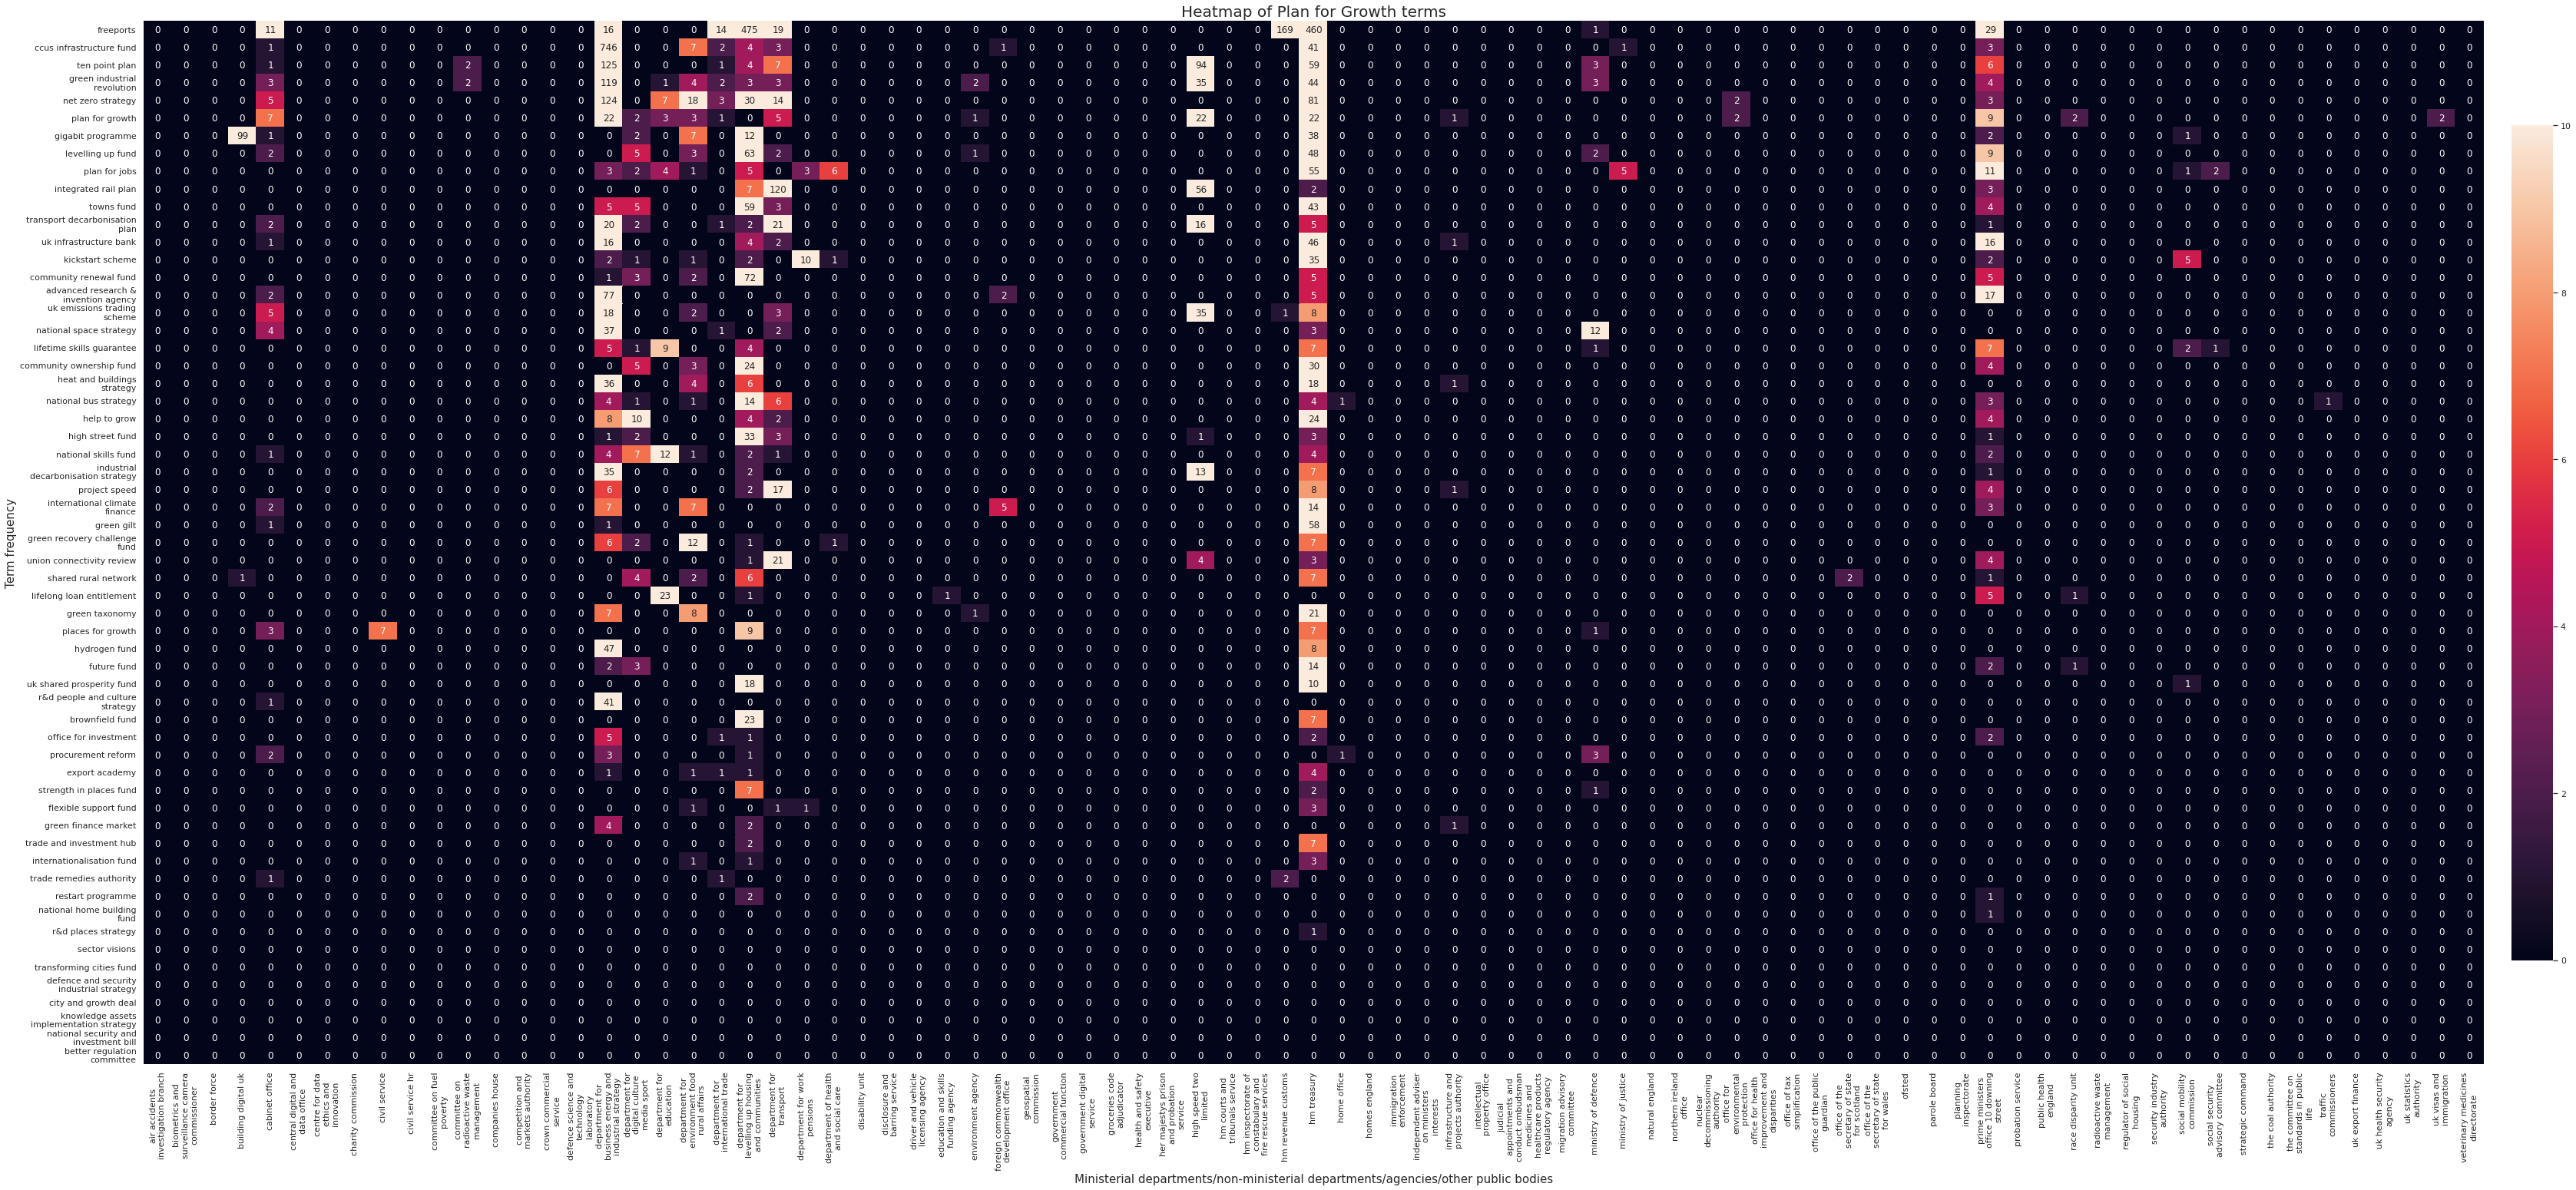

In [ ]:
#@title Heatmap of Plan for Growth terms
#@markdown *Last execution speed: 17s*
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
start_time = time.time()


# Set the width and height of the figure
plt.figure(figsize = (65, 25))


# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)


# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(
    pfg_term_frequency.iloc[:, 0:len(pfg_term_frequency.columns)-1],
    annot = True, vmin = 0, vmax = 10,
    cmap = pal, cbar = True, cbar_kws = {
        "shrink":0.8, "ticks":range(0, 11, 2), "pad":0.01
    },
    yticklabels = True, xticklabels = True, fmt = "g"
)
wrap_xlabels(heatmap, 20)
wrap_ylabels(heatmap, 25)
plt.title("Heatmap of Plan for Growth terms", fontsize = 20)
plt.xlabel("Ministerial departments/non-ministerial departments/agencies/other public bodies", fontsize = 15)
plt.ylabel("Term frequency", fontsize = 15)
heatmap
plt.savefig("/content/pfg_fig.jpg", format = "jpeg", dpi = 300)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:00:19


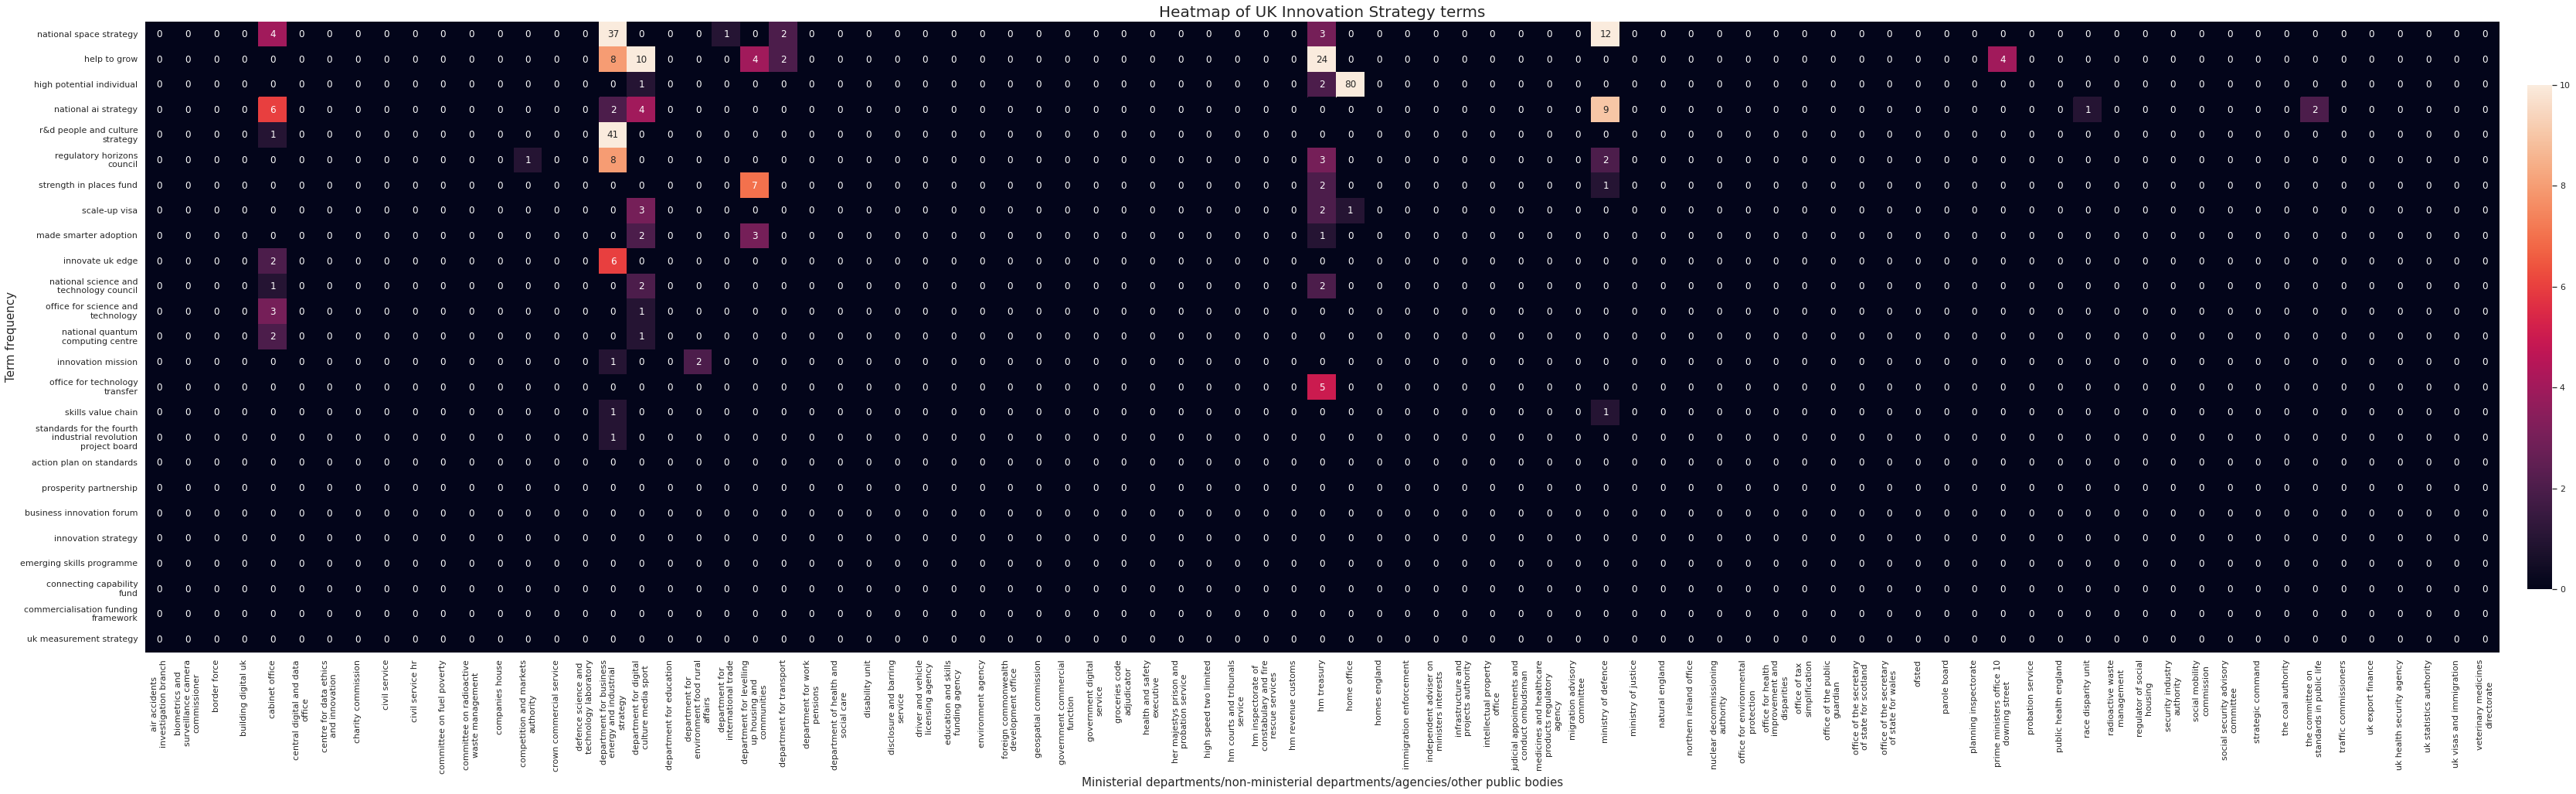

In [ ]:
#@title Heatmap of UK Innovation Strategy terms
#@markdown *Last execution speed: 9s*
start_time = time.time()


# Set the width and height of the figure
plt.figure(figsize = (65, 15))


# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)


# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(
    ukis_term_frequency.iloc[:, 0:len(ukis_term_frequency.columns)-1],
    annot = True, vmin = 0, vmax = 10,
    cmap = pal, cbar = True, cbar_kws = {
        "shrink":0.8, "ticks":range(0, 11, 2), "pad":0.01
    },
    yticklabels = True, xticklabels = True, fmt = "g"
)
wrap_xlabels(heatmap, 25)
wrap_ylabels(heatmap, 25)
plt.title("Heatmap of UK Innovation Strategy terms", fontsize = 20)
plt.xlabel("Ministerial departments/non-ministerial departments/agencies/other public bodies", fontsize = 15)
plt.ylabel("Term frequency", fontsize = 15)
heatmap
plt.savefig("/content/ukis_fig.jpg", format = "jpeg", dpi = 300)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

### Heatmaps of search term frequencies (ministries subset)

In [ ]:
#@title Create subset dataframe
ministries_list = ["cabinet office",
                   "department for business energy and industrial strategy",
                   "department for digital culture media sport",
                   "department for education",
                   "department for environment food rural affairs",
                   "department for international trade",
                   "department for levelling up housing and communities",
                   "department for transport", "department for work pensions",
                   "department of health and social care",
                   "foreign commonwealth development office", "hm treasury",
                   "home office", "ministry of defence", "ministry of justice",
                   "northern ireland office",
                   "office of the secretary of state for scotland",
                   "office of the secretary of state for wales",
                   "prime ministers office 10 downing street",
                   "uk export finance"
]

pfg_ministries = pfg_term_frequency[ministries_list]

ukis_ministries = ukis_term_frequency[ministries_list]

In [ ]:
#@title Sorting by weighted averages
pfg_ministries["Weighted Average Citation"] = 0
for i in range(0, len(pfg_ministries.index.values)):
    pfg_ministries.loc[
                       pfg_ministries.index.values.tolist()[i],
                       "Weighted Average Citation"
    ] = (
        pfg_ministries.loc[
                           pfg_ministries.index.values.tolist()[i]
        ].sum() * (
            (pfg_ministries.loc[
                                pfg_ministries.index.values.tolist()[i]
            ] != 0).sum() / (len(pfg_ministries.columns) - 1)
        )
    )

ukis_ministries["Weighted Average Citation"] = 0
for i in range(0, len(ukis_ministries.index.values)):
    ukis_ministries.loc[
                        ukis_ministries.index.values.tolist()[i],
                        "Weighted Average Citation"
    ] = (
        ukis_ministries.loc[
                            ukis_ministries.index.values.tolist()[i]
        ].sum() * (
            (
                ukis_ministries.loc[
                                    ukis_ministries.index.values.tolist()[i]
                ] != 0
            ).sum() / (len(ukis_ministries.columns) - 1)
        )
    )

pfg_ministries.sort_values(
    "Weighted Average Citation", ascending = False, inplace = True
)
ukis_ministries.sort_values(
    "Weighted Average Citation", ascending = False, inplace = True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [ ]:
#@title Proportion of term frequencies = 0
zeroes_pfg = (pfg_ministries.iloc[:, :-1] == 0).sum().sum() / (len(pfg_ministries.index) * (len(pfg_ministries.columns) - 1))
zeroes_ukis = (ukis_ministries.iloc[:, :-1] == 0).sum().sum() / (len(ukis_ministries.index) * (len(ukis_ministries.columns) - 1))
print("Proportion of term frequencies = 0 in Plan for Growth:", zeroes_pfg, sep = " ")
print("Proportion of term frequencies = 0 in UK Innovation Strategy:", zeroes_ukis, sep = " ")

Proportion of term frequencies = 0 in Plan for Growth: 0.7728813559322034
Proportion of term frequencies = 0 in UK Innovation Strategy: 0.904


Execution time: 00:00:06


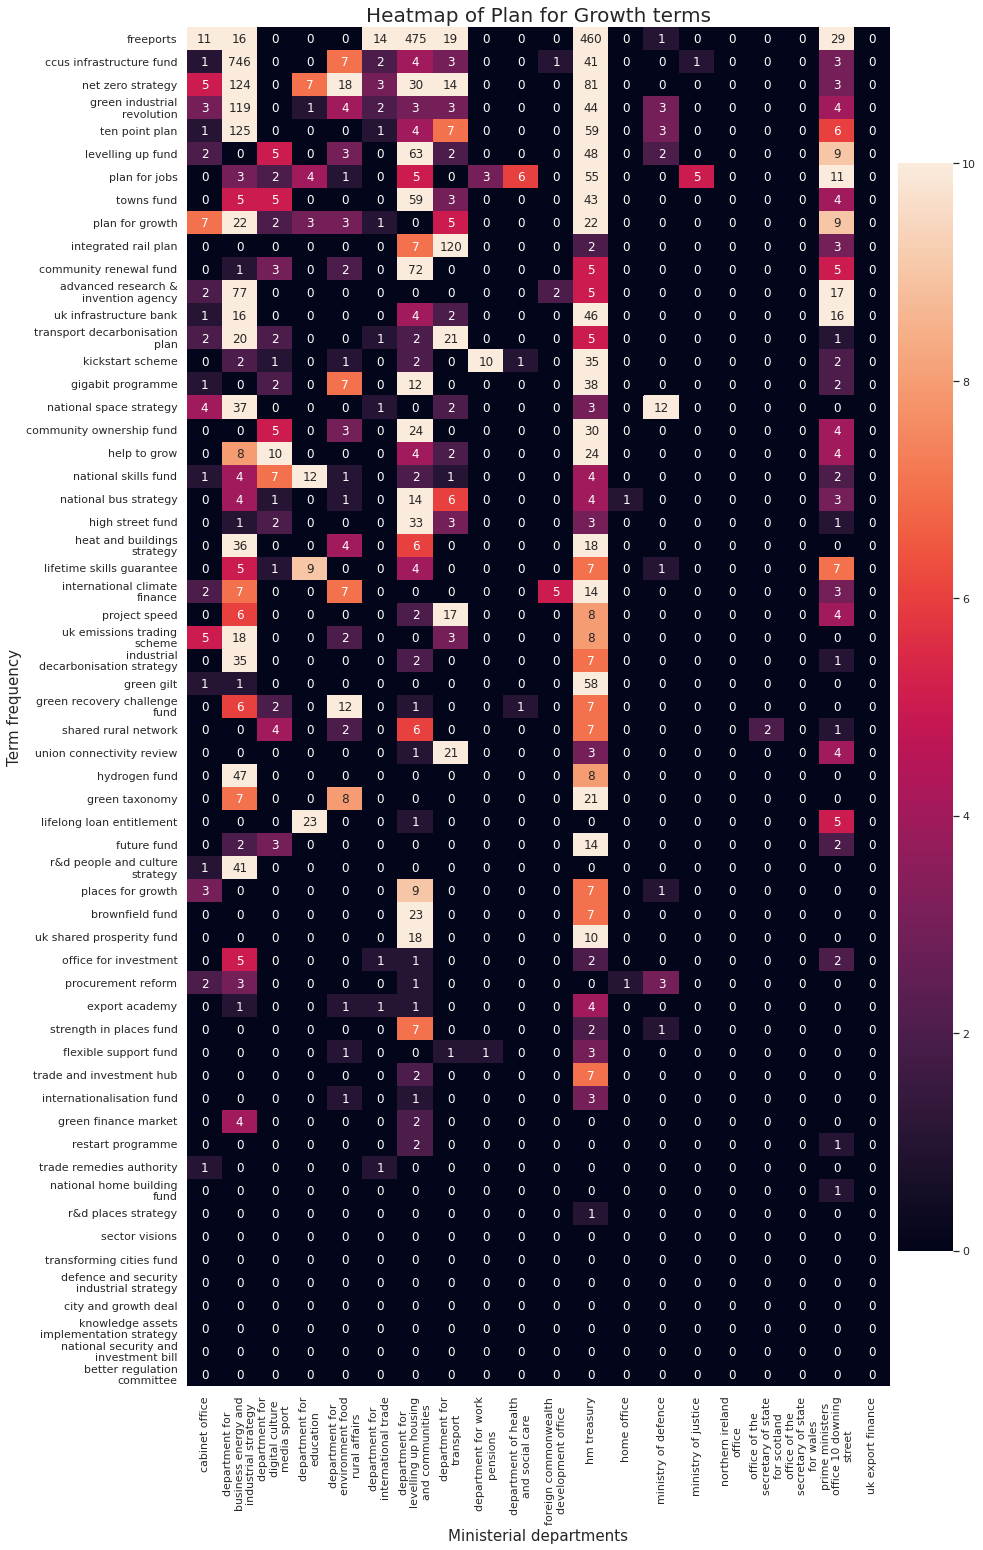

In [ ]:
#@title Heatmap of Plan for Growth terms (ministries subset)
#@markdown *Last execution speed: 4s*
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
start_time = time.time()


# Set the width and height of the figure
plt.figure(figsize = (15, 25))


# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)


# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(
    pfg_ministries.iloc[:, 0:len(pfg_ministries.columns)-1],
    annot = True, vmin = 0, vmax = 10,
    cmap = pal, cbar = True, cbar_kws = {
        "shrink":0.8, "ticks":range(0, 11, 2), "pad":0.01
    },
    yticklabels = True, xticklabels = True, fmt = "g"
)
wrap_xlabels(heatmap, 20)
wrap_ylabels(heatmap, 25)
plt.title("Heatmap of Plan for Growth terms", fontsize = 20)
plt.xlabel("Ministerial departments", fontsize = 15)
plt.ylabel("Term frequency", fontsize = 15)
heatmap
plt.savefig("/content/pfg_ministries_fig.jpg", format = "jpeg", dpi = 300)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:00:03


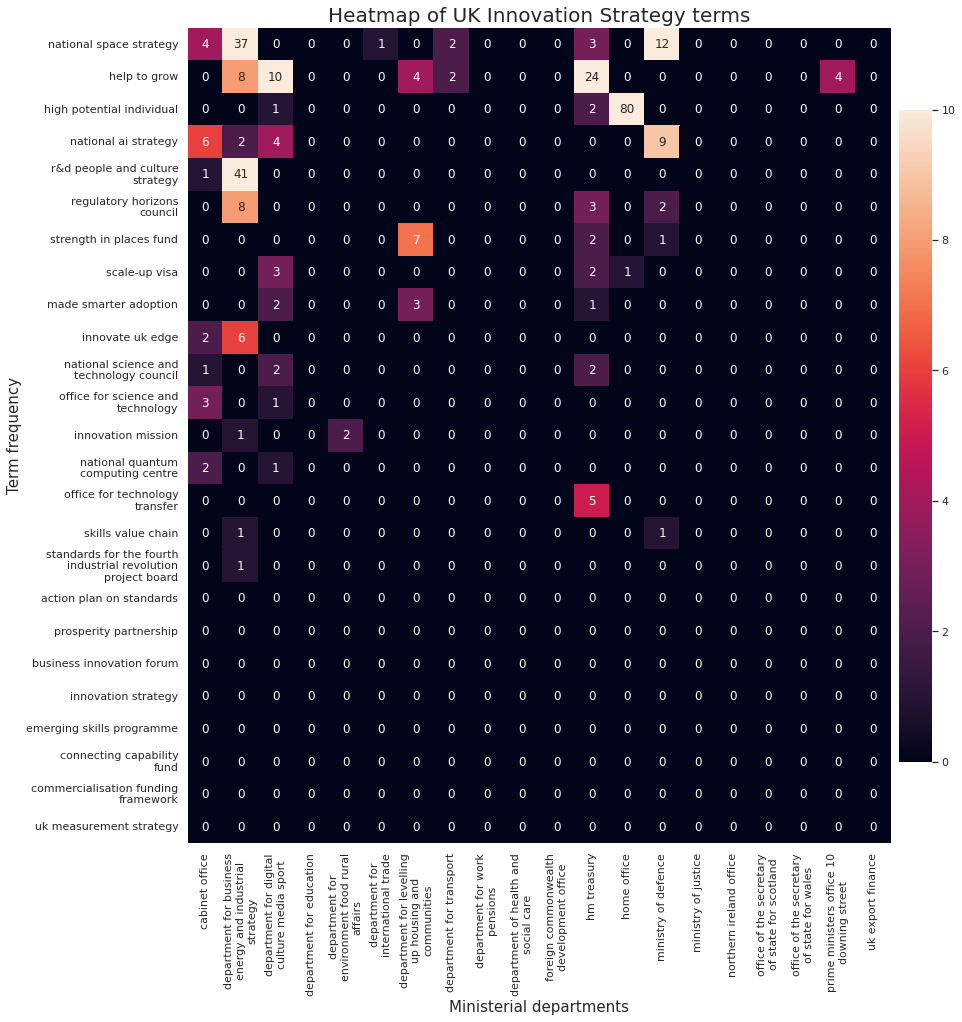

In [ ]:
#@title Heatmap of UK Innovation Strategy terms (ministries subset)
#@markdown *Last execution speed: 1s*
start_time = time.time()


# Set the width and height of the figure
plt.figure(figsize = (15, 15))


# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)


# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(
    ukis_ministries.iloc[:, 0:len(ukis_ministries.columns)-1],
    annot = True, vmin = 0, vmax = 10,
    cmap = pal, cbar = True, cbar_kws = {
        "shrink":0.8, "ticks":range(0, 11, 2), "pad":0.01
    },
    yticklabels = True, xticklabels = True, fmt = "g"
)
wrap_xlabels(heatmap, 25)
wrap_ylabels(heatmap, 25)
plt.title("Heatmap of UK Innovation Strategy terms", fontsize = 20)
plt.xlabel("Ministerial departments", fontsize = 15)
plt.ylabel("Term frequency", fontsize = 15)
heatmap
plt.savefig("/content/ukis_ministries_fig.jpg", format = "jpeg", dpi = 300)


# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

## **Network graph of policy permeation**

In this section, the term frequencies are used to construct network graphs that highlight the degree of connectedness between UK ministerial departments. To construct a network, each ministerial department in our sample is represented by a node (vertex). Each edge (link) emanating from a node represents the extent of *connectedness* between any two ministries within the context of Plan for Growth/UK Innovation Strategy.

The network graphs are generated using [Fruchterman-Reingold](https://www.sciencedirect.com/topics/computer-science/reingold-layout) layout, a force-directed algorithm which assigns a repelling force to all vertices in the graph—effectively pushing apart vertices so they don't overlap (similar to the behaviour of electrically charged particles)—and an attraction force between each adjacent vertices pair, pulling those vertices closer the stronger the edge's strength (similar to springs of differing pulling strength).

In [ ]:
#@title Nth triangular number function
def triangular_number(n):
    return (n * (n + 1)) // 2

### Network graph of policy permeation: $e_{u, v} = \frac{\sum_{t} w_{t, u, v}}{n}$ where $w_{t, u, v} \in(0,1)$
---
In this network, each node represents a ministry and each edge represents the number of times a Plan for Growth/UK Innovation policy is cited by a given pair of ministries. We propose a simple measure to measure the weight of each edge; for any given ministry pairs $(u, v)$, their weighted edge, $e_{u, v}$, is given by:

$$
e_{u, v} = \frac{\sum_{t} w_{t, u, v}}{n} \quad \text{where}\ w_{t, u, v} = \left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ \ tf_{t, u} > 0\ \ \text{and}\ \ tf_{t, v} > 0\\
    0, & \text{otherwise}
  \end{array}\right.
$$

Here, $w_{t, u, v}$ represents the total number of instances where a given policy, $t$, is cited at least once in publications from ministry $u$ and $v$, separately. In other words, for a given policy, $t$, $w_{t, u, v}$ takes the value 1 if the term frequency, $tf$, for that policy is non-zero for both ministries $u$ and $v$. $n$ is the total number of search terms in the dictionary.

**Examples**

* The term frequency of `freeports` is 11 and 16 for the Cabinet Office and BEIS respectively. Since $tf_{\text{freeports}}$ is non-zero for both the Cabinet Office and BEIS, $w_{\text{freeports}, \text{Cabinet Office}, \text{BEIS}}$ takes the value of 1.
* Conversely, the term frequency for `levelling up fund` is 2 and 0 for the Cabinet Office and BEIS, respectively. Here, $w_{\text{levelling up fund}, \text{Cabinet Office}, \text{BEIS}}$ takes the value 0 since $tf_{\text{levelling up fund}}$ is 0 for at least one of the ministries in this pair.

In [ ]:
#@title Undirected network graph dataframe for Plan for Growth
# Create placeholder dataframe
pfg_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(pfg_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with instances of non-zero policy pairs 
row = 0
for i in range(0, len(pfg_ministries.columns) - 1):
    for j in range(i, len(pfg_ministries.columns) - 1):
        if i != j:
            pfg_ministries_net.dept1[row] = pfg_ministries.columns[i]
            pfg_ministries_net.dept2[row] = pfg_ministries.columns[j]
            for k in range(0, len(pfg_ministries.index)):
                if pfg_ministries.iloc[k, i] != 0 and pfg_ministries.iloc[k, j] != 0:
                    pfg_ministries_net.edge[row] += 1
            row += 1

pfg_ministries_net["edge"] = pfg_ministries_net["edge"]/len(pfg_term_frequency.index)


# Remove edges with value 0 and sort dataframe by weighted edges
pfg_ministries_net = pfg_ministries_net.sort_values(
    "edge", ascending = False
)
pfg_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    pfg_ministries_net = pfg_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#@title Undirected network graph dataframe for UK Innovation Strategy
# Create placeholder dataframe
ukis_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(ukis_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with instances of non-zero policy pairs 
row = 0
for i in range(0, len(ukis_ministries.columns) - 1):
    for j in range(i, len(ukis_ministries.columns) - 1):
        if i != j:
            ukis_ministries_net.dept1[row] = ukis_ministries.columns[i]
            ukis_ministries_net.dept2[row] = ukis_ministries.columns[j]
            for k in range(0, len(ukis_ministries.index)):
                if ukis_ministries.iloc[k, i] != 0 and ukis_ministries.iloc[k, j] != 0:
                    ukis_ministries_net.edge[row] += 1
            row += 1

ukis_ministries_net["edge"] = ukis_ministries_net["edge"]/len(ukis_term_frequency.index)


# Remove edges with value 0 and sort dataframe by weighted edges
ukis_ministries_net = ukis_ministries_net.sort_values(
    "edge", ascending = False
)
ukis_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    ukis_ministries_net = ukis_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Graph with 20 nodes and 190 edges


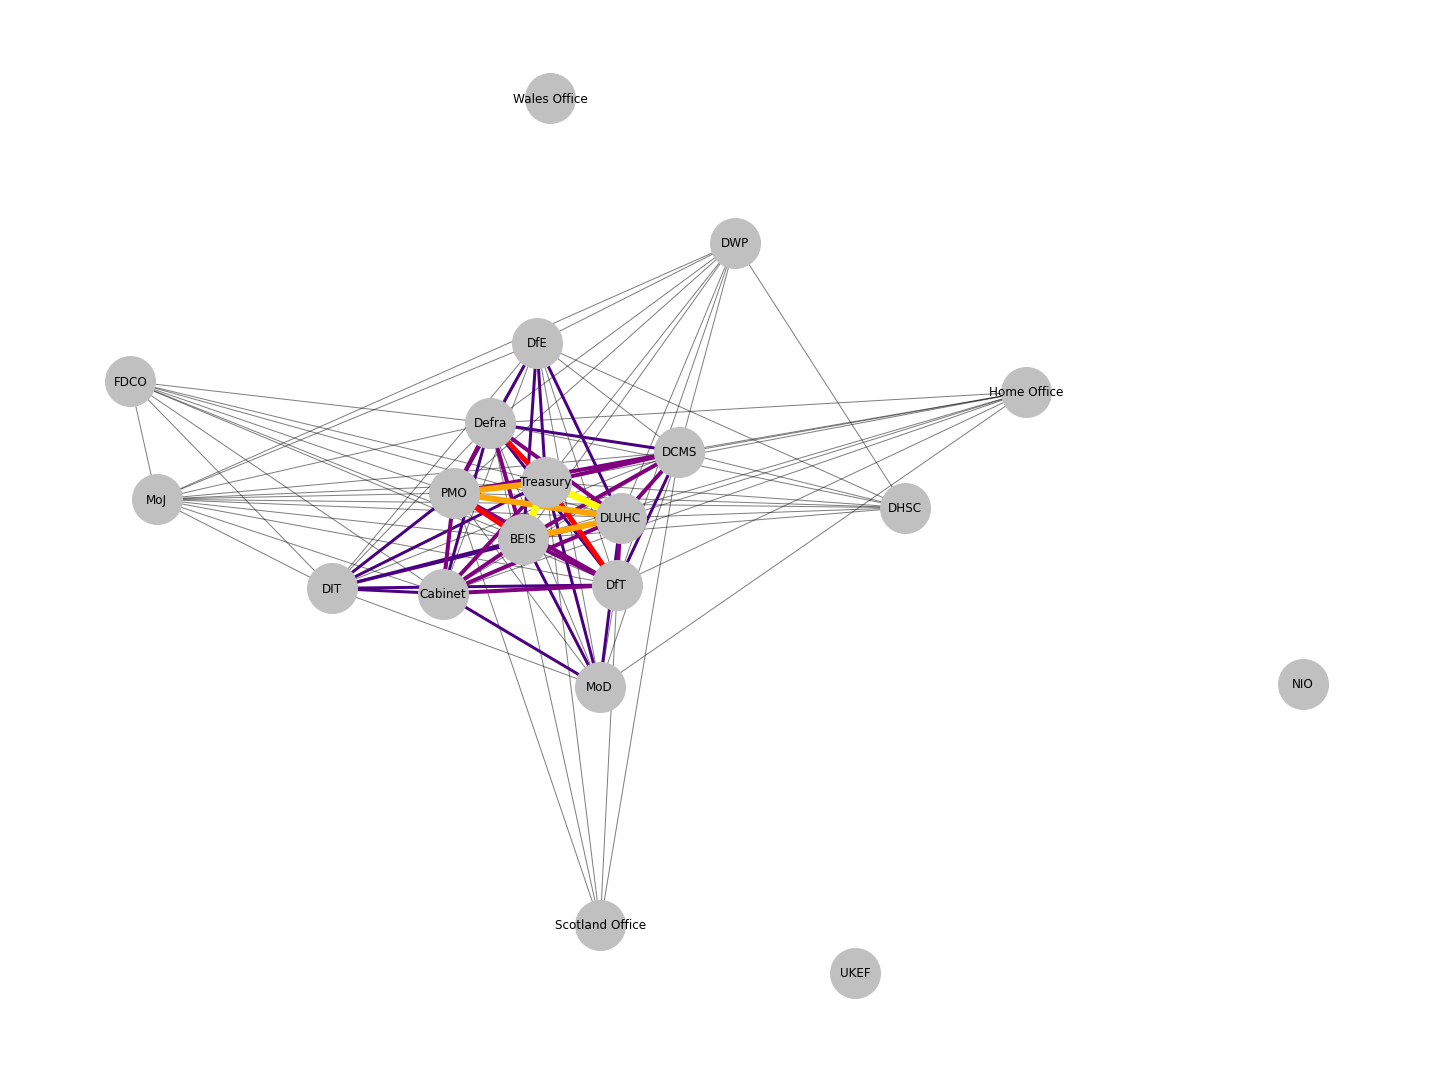

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Force-directed network graph of Plan for Growth policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(pfg_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0.5]
e_4 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0.4 and d["edge"] <= 0.5]
e_3 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0.3 and d["edge"] <= 0.4]
e_2 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0.2 and d["edge"] <= 0.4]
e_1 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0.1 and d["edge"] <= 0.2]
e_0 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 0.1]
e_null = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (20, 15))
# Position configuration for all nodes; seed for reproducibility
pos = nx.fruchterman_reingold_layout(pfg_network, weight = "edge", seed = 7, k = 0.5)
# Generate nodes
nx.draw_networkx_nodes(
    pfg_network, pos, node_size = 2500, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_0, width = 1, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid"
)
# Label nodes
nx.draw_networkx_labels(
    pfg_network, pos, font_size = 12, font_family = "sans-serif"
)
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("/content/pfg_network.png", format = "png", dpi = 300)

Graph with 20 nodes and 190 edges


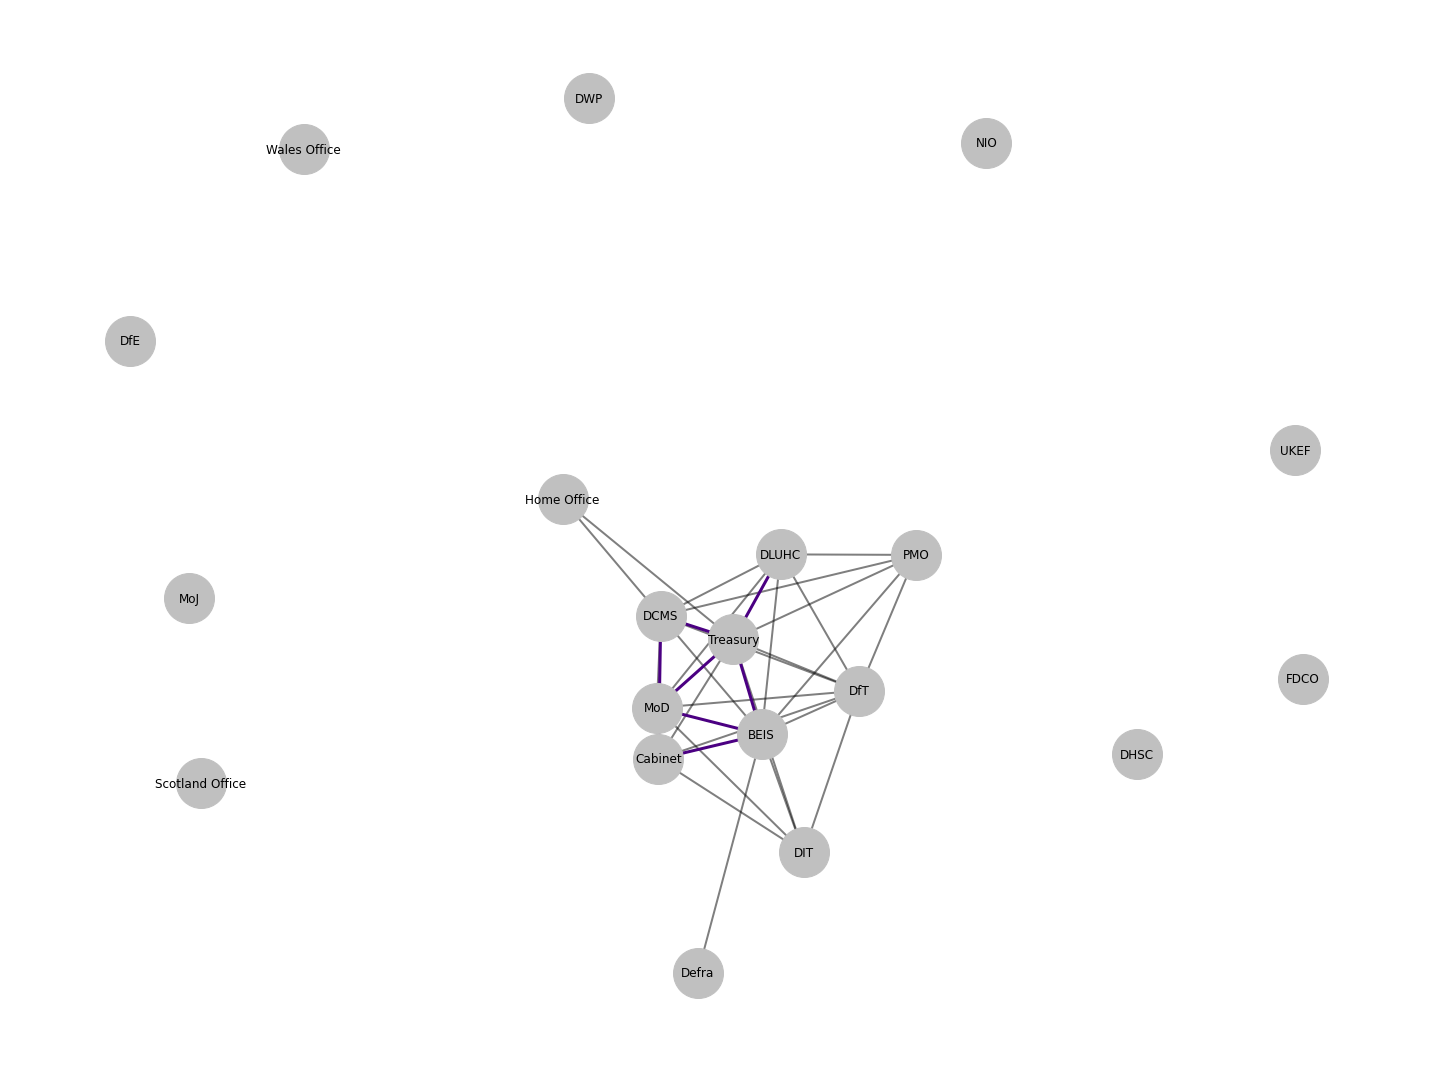

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Force-directed network graph of UK Innovation Strategy policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(ukis_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0.5]
e_4 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0.4 and d["edge"] <= 0.5]
e_3 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0.3 and d["edge"] <= 0.4]
e_2 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0.2 and d["edge"] <= 0.4]
e_1 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0.1 and d["edge"] <= 0.2]
e_0 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 0.1]
e_null = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (20, 15))
# Position configuration for all nodes; seed for reproducibility
pos = nx.fruchterman_reingold_layout(ukis_network, weight = "edge", seed = 10, k = 0.3)
# Generate nodes
nx.draw_networkx_nodes(
    ukis_network, pos, node_size = 2500, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_0, width = 2, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid",
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid",
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid",
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid",
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid",
)
# Label nodes
nx.draw_networkx_labels(ukis_network, pos, font_size = 12, font_family = "sans-serif")
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("/content/ukis_network.jpg", format = "jpeg", dpi = 300)

In [ ]:
#@title Node-degree barplot
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go


# Create graph object
pfg_degree = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
ukis_degree = nx.from_pandas_edgelist(
    ukis_ministries_net[(ukis_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Create dataframe of node degrees
degree_df = pd.DataFrame(
    0, index = list(pfg_network.nodes), columns = ["pfg", "ukis"]
)


# Populate node dataframe
for node in list(pfg_degree.nodes):
    for i in range(0, len(list(pfg_network.nodes))):
        if node == degree_df.index[i]:
            degree_df.loc[node, "pfg"] = pfg_degree.degree[node]

for node in list(ukis_degree.nodes):
    for i in range(0, len(list(pfg_network.nodes))):
        if node == degree_df.index[i]:
            degree_df.loc[node, "ukis"] = ukis_degree.degree[node]

degree_df["sum"] = degree_df["pfg"] + degree_df["ukis"]

# Sort node degrees in descending order
degree_df.sort_values(
    by = "sum", ascending = False, inplace = True
)


# Set plotly theme
pio.templates.default = "plotly_white"
# Generate grouped bar chart
fig = go.Figure()
fig.add_trace(go.Bar(
    name = "Plan for Growth", x = degree_df.index, y = degree_df["pfg"],
    marker_color = "slategrey"
))
fig.add_trace(go.Bar(
    name = "UK Innovation Strategy", x = degree_df.index, y = degree_df["ukis"],
    marker_color = "lightsteelblue"
))
# Change the bar mode
fig.update_layout(
    title = "Ministries ranked by node degrees<br><sup>Degree of a given node is the number of edges which involve the node as an endpoint</sup>",
    yaxis = {
        "title": "Degrees"
    },
    xaxis = {
        "title": "Nodes/Ministries"
    },
    legend = {
        "x": 0.8, "y": 0.9, "font_size": 15
    },
    font_family = "sans-serif", autosize = False, width = 1200, height = 700,
    barmode = "stack", bargap = 0.15, bargroupgap = 0.1, xaxis_tickangle = -30
)
fig.show()

In [ ]:
#@title Adjacency matrix
import networkx as nx           # Network analysis in Python
import numpy as np              # linear algebra
from numpy import linalg as LA


# Create graph object wtih nodes with zero edges 
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
pfg_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])

# Array of adjacency matrix elements
# Adjacency matrix using NetworkX function
# A = nx.adjacency_matrix(pfg_network, weight = "edge")
A = nx.to_numpy_array(pfg_network)
print(A)

matrix = []
for array in A:
    matrix.append(A)

w, v = LA.eig(A)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.

In [ ]:
#@title Local clustering coefficients
import networkx as nx           # Network analysis in Python


# Create graph object wtih nodes with zero edges 
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
pfg_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])

clustering = []
for i in range(0, len(list(pfg_network.nodes))):
    temp = []
    temp.append(list(pfg_network.nodes)[i])
    temp.append(
        round(nx.clustering(pfg_network, list(pfg_network.nodes)[i]), 5)
    )
    clustering.append(temp)

pfg_clustering = pd.DataFrame(
    clustering,
    columns = ["Node", "Clustering"]
)
pfg_clustering.sort_values(
    ["Clustering", "Node"], ascending = False, inplace = True
)
pfg_clustering.reset_index(drop = True, inplace = True)
pfg_clustering

,Node,Clustering
0,Scotland Office,1.00000
1,Home Office,1.00000
2,FDCO,1.00000
3,DHSC,1.00000
4,DWP,0.97778
5,MoD,0.96364
6,DIT,0.93939
7,DfE,0.89744
8,Cabinet,0.89744
9,MoJ,0.88462


In [ ]:
#@title Plan for Growth network properties
import networkx as nx           # Network analysis in Python


# Create graph object wtih nodes with zero edges 
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
pfg_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])


# Nodes, edges, average degree
N, K = pfg_network.order(), pfg_network.size()
avg_deg = float(K) / N
print(" " * 12, "Plan for Growth Network Properties", sep = "")
print("—" * 57, "\n", "—" * 57, sep = "")
print("Nodes:", N)
print("Edges:", K)
print("Average degree:", avg_deg)
# Clustering coefficients
print("—" * 57)
for i in range(0, len(list(pfg_network.nodes))):
    print(
        list(pfg_network.nodes)[i],
        "clustering coefficient:",
        round(nx.clustering(pfg_network, list(pfg_network.nodes)[i]), 3)
    )
print(
    "Network average clustering coefficient:",
    round(nx.average_clustering(pfg_network), 3)
)
print(
    "Network transitivity/global clustering coefficient:",
    round(nx.transitivity(pfg_network), 3)
)
print("—" * 57, "\n", "—" * 57, sep = "")

            Plan for Growth Network Properties
—————————————————————————————————————————————————————————
—————————————————————————————————————————————————————————
Nodes: 20
Edges: 106
Average degree: 5.3
—————————————————————————————————————————————————————————
DLUHC clustering coefficient: 0.75
Treasury clustering coefficient: 0.75
BEIS clustering coefficient: 0.819
PMO clustering coefficient: 0.75
Defra clustering coefficient: 0.75
DfT clustering coefficient: 0.857
Cabinet clustering coefficient: 0.897
DCMS clustering coefficient: 0.781
DIT clustering coefficient: 0.939
MoD clustering coefficient: 0.964
DfE clustering coefficient: 0.897
FDCO clustering coefficient: 1.0
DHSC clustering coefficient: 1.0
DWP clustering coefficient: 0.978
Home Office clustering coefficient: 1.0
MoJ clustering coefficient: 0.885
Scotland Office clustering coefficient: 1.0
UKEF clustering coefficient: 0
NI Office clustering coefficient: 0
Wales Office clustering coefficient: 0
Network average clustering co

In [ ]:
#@title Plan for Growth network centrality measures
import networkx as nx           # Network analysis in Python


# Create graph object wtih nodes with zero edges 
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
pfg_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])

centrality = []
for i in range(0, len(list(pfg_network.nodes))):
    temp = []
    temp.append(list(pfg_network.nodes)[i])
    temp.append(
        round(nx.degree_centrality(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.closeness_centrality(pfg_network, wf_improved = True)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.harmonic_centrality(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.betweenness_centrality(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.load_centrality(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.eigenvector_centrality(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.katz_centrality_numpy(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.pagerank(pfg_network)[list(pfg_network.nodes)[i]], 5)
    )
    centrality.append(temp)

pfg_centrality = pd.DataFrame(
    centrality,
    columns = [
               "Node", "Degree", "Closeness", "Harmonic", "Betweenness",
               "Load", "Eigenvector", "Katz", "PageRank"
    ]
)
pfg_centrality.sort_values(
    ["Degree", "Node"], ascending = False, inplace = True
)
pfg_centrality.reset_index(drop = True, inplace = True)
pfg_centrality

,Node,Degree,Closeness,Harmonic,Betweenness,Load,Eigenvector,Katz,PageRank
0,Treasury,0.84211,0.84211,16.0,0.02724,0.02724,0.28627,0.29032,0.07197
1,PMO,0.84211,0.84211,16.0,0.02724,0.02724,0.28627,0.29032,0.07197
2,Defra,0.84211,0.84211,16.0,0.02724,0.02724,0.28627,0.29032,0.07197
3,DLUHC,0.84211,0.84211,16.0,0.02724,0.02724,0.28627,0.29032,0.07197
4,DCMS,0.78947,0.79257,15.5,0.02110,0.02110,0.27314,0.27495,0.06787
5,BEIS,0.78947,0.79257,15.5,0.01408,0.01408,0.27861,0.28419,0.06727
6,DfT,0.73684,0.74854,15.0,0.00918,0.00918,0.26562,0.26918,0.06316
7,MoJ,0.68421,0.70914,14.5,0.00652,0.00652,0.24982,0.24935,0.05918
8,DfE,0.68421,0.70914,14.5,0.00556,0.00556,0.25231,0.25343,0.05906
9,Cabinet,0.68421,0.70914,14.5,0.00548,0.00548,0.25131,0.25195,0.05911


In [ ]:
#@title UK Innovation Strategy network properties
import networkx as nx           # Network analysis in Python


# Create graph object wtih nodes with zero edges 
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net[(ukis_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
ukis_network.add_nodes_from(
    ["UKEF", "NI Office", "Wales Office", "Scotland Office", "FDCO", "MoJ",
     "DWP", "DHSC", "DfE"]
)

# Nodes, edges, average degree
N, K = ukis_network.order(), ukis_network.size()
avg_deg = float(K) / N
print(" " * 9, "UK Innovation Strategy Network Properties", sep = "")
print("—" * 57, "\n", "—" * 57, sep = "")
print("Nodes:", N)
print("Edges:", K)
print("Average degree:", avg_deg)
# Clustering coefficients
print("—" * 57)
for i in range(0, len(list(ukis_network.nodes))):
    print(
        list(ukis_network.nodes)[i],
        "clustering coefficient:",
        round(nx.clustering(ukis_network, list(ukis_network.nodes)[i]), 3)
    )
print(
    "Network average clustering coefficient:",
    round(nx.average_clustering(ukis_network), 3)
)
print(
    "Network transitivity/global clustering coefficient:",
    round(nx.transitivity(ukis_network), 3)
)
print("—" * 57, "\n", "—" * 57, sep = "")

         UK Innovation Strategy Network Properties
—————————————————————————————————————————————————————————
—————————————————————————————————————————————————————————
Nodes: 20
Edges: 33
Average degree: 1.65
—————————————————————————————————————————————————————————
DCMS clustering coefficient: 0.679
Treasury clustering coefficient: 0.639
Cabinet clustering coefficient: 0.933
BEIS clustering coefficient: 0.611
MoD clustering coefficient: 0.857
DLUHC clustering coefficient: 0.933
Home Office clustering coefficient: 1.0
DfT clustering coefficient: 0.786
DIT clustering coefficient: 1.0
PMO clustering coefficient: 1.0
Defra clustering coefficient: 0
UKEF clustering coefficient: 0
NI Office clustering coefficient: 0
Wales Office clustering coefficient: 0
Scotland Office clustering coefficient: 0
FDCO clustering coefficient: 0
MoJ clustering coefficient: 0
DWP clustering coefficient: 0
DHSC clustering coefficient: 0
DfE clustering coefficient: 0
Network average clustering coefficient: 0.422
N

In [ ]:
#@title UK Innovation Strategy network centrality measures
import networkx as nx           # Network analysis in Python


# Create graph object wtih nodes with zero edges 
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net[(ukis_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
ukis_network.add_nodes_from(
    ["UKEF", "NI Office", "Wales Office", "Scotland Office", "FDCO", "MoJ",
     "DWP", "DHSC", "DfE"]
)

centrality = []
for i in range(0, len(list(ukis_network.nodes))):
    temp = []
    temp.append(list(ukis_network.nodes)[i])
    temp.append(
        round(nx.degree_centrality(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.closeness_centrality(ukis_network, wf_improved = True)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.harmonic_centrality(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.betweenness_centrality(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.load_centrality(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.eigenvector_centrality(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.katz_centrality_numpy(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    temp.append(
        round(nx.pagerank(ukis_network)[list(ukis_network.nodes)[i]], 5)
    )
    centrality.append(temp)

ukis_centrality = pd.DataFrame(
    centrality,
    columns = [
               "Node", "Degree", "Closeness", "Harmonic", "Betweenness",
               "Load", "Eigenvector", "Katz", "PageRank"
    ]
)
ukis_centrality.sort_values(
    ["Degree", "Node"], ascending = False, inplace = True
)
ukis_centrality.reset_index(drop = True, inplace = True)
ukis_centrality

,Node,Degree,Closeness,Harmonic,Betweenness,Load,Eigenvector,Katz,PageRank
0,Treasury,0.47368,0.47847,9.50000,0.03470,0.03470,0.38561,0.35436,0.11702
1,BEIS,0.47368,0.47847,9.50000,0.06101,0.06101,0.37905,0.35132,0.12206
2,DfT,0.42105,0.43860,9.00000,0.00838,0.00838,0.37213,0.33955,0.10256
3,DCMS,0.42105,0.43860,9.00000,0.02427,0.02427,0.35319,0.33077,0.10534
4,MoD,0.36842,0.40486,8.50000,0.00380,0.00380,0.33946,0.31583,0.09086
5,DLUHC,0.31579,0.37594,8.00000,0.00117,0.00117,0.30168,0.28965,0.07942
6,Cabinet,0.31579,0.37594,8.00000,0.00117,0.00117,0.30138,0.28950,0.07939
7,PMO,0.26316,0.35088,7.50000,0.00000,0.00000,0.25883,0.26094,0.06807
8,DIT,0.26316,0.35088,7.50000,0.00000,0.00000,0.25680,0.25943,0.06790
9,Home Office,0.10526,0.27701,5.83333,0.00000,0.00000,0.10673,0.16288,0.03439


In [ ]:
#@title List of influential nodes in a graph using VoteRank algorithm
print(nx.voterank(pfg_network))
print(nx.voterank(ukis_network))

['DLUHC', 'Treasury', 'PMO', 'Defra', 'BEIS', 'DCMS', 'DfT', 'MoJ', 'Cabinet', 'DfE', 'DIT', 'MoD', 'DWP']
['Treasury', 'BEIS', 'DCMS', 'DfT', 'Cabinet']


#### Interactive [`Plotly`](https://plotly.com/graphing-libraries/) network graphs

In [ ]:
import networkx as nx           # Network analysis in Python
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# Create graph object wtih nodes with zero edges 
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net[(pfg_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
pfg_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])


# Set plotly theme
pio.templates.default = "plotly_white"
# Position configuration for all nodes; seed for reproducibility
pos = nx.fruchterman_reingold_layout(pfg_network, weight = "edge", seed = 7)
# Adding positions of the nodes to the graph
for n, p in pos.items():
    pfg_network.nodes[n]['pos'] = p

# Adding nodes and edges to the Plotly API
edge_trace = go.Scatter(
    x = [],
    y = [],
    line = {"width": 1.5, "color": "#888"},
    hoverinfo = "none",
    mode = "lines"
)

for edge in pfg_network.edges():
    x0, y0 = pfg_network.nodes[edge[0]]['pos']
    x1, y1 = pfg_network.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x = [],
    y = [],
    text = [],
    mode = "markers",
    hoverinfo = "text",
    marker = {
        "showscale": True,
        "colorscale": px.colors.sequential.Inferno,
        "color": [],
        "size": 20,
        "colorbar": {
            "thickness": 20,
            "title": "Node degrees",
            "xanchor": "right",
            "titleside": "right"
        },
        "line": {"width": 0},
    }
)

for node in pfg_network.nodes():
    x, y = pfg_network.nodes[node]["pos"]
    node_trace["x"] += tuple([x])
    node_trace["y"] += tuple([y])

# Coloring based on the number of connections of each node
for node, adjacencies in enumerate(pfg_network.adjacency()):
    node_trace["marker"]["color"] += tuple([len(adjacencies[1])])
    node_info = adjacencies[0] + " degree: " + str(len(adjacencies[1]))
    node_trace["text"] += tuple([node_info])

# Plot the figure
fig = go.Figure(
    data = [edge_trace, node_trace],
    layout = go.Layout(
        title = "Plan for Growth policy networks<br><sup>Node degree reflected in colour shading</sup>",
        font_family = "Cascadia Code",
        showlegend = False,
        hovermode = "closest",
        margin = {"b": 20, "l": 5, "r": 5, "t": 40},
        xaxis = {"showgrid": False, "zeroline": False, "showticklabels": False},
        yaxis = {"showgrid": False, "zeroline": False, "showticklabels": False},
        autosize = False,
        width = 900,
        height = 900
    )
)

iplot(fig)

In [ ]:
import networkx as nx           # Network analysis in Python
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# Create graph object wtih nodes with zero edges 
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net[(ukis_ministries_net != 0).all(1)],
    source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)
# Add nodes with zero edges 
ukis_network.add_nodes_from(["UKEF", "NI Office", "Wales Office"])


# Set plotly theme
pio.templates.default = "plotly_white"
# Position configuration for all nodes; seed for reproducibility
pos = nx.fruchterman_reingold_layout(ukis_network, weight = "edge", seed = 7)
# Adding positions of the nodes to the graph
for n, p in pos.items():
    ukis_network.nodes[n]['pos'] = p

# Adding nodes and edges to the Plotly API
edge_trace = go.Scatter(
    x = [],
    y = [],
    line = {"width": 5, "color": "#888"},
    hoverinfo = "none",
    mode = "lines"
)

for edge in ukis_network.edges():
    x0, y0 = ukis_network.nodes[edge[0]]['pos']
    x1, y1 = ukis_network.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x = [],
    y = [],
    text = [],
    mode = "markers",
    hoverinfo = "text",
    marker = {
        "showscale": True,
        "colorscale": px.colors.sequential.Inferno,
        "color": [],
        "size": 30,
        "colorbar": {
            "thickness": 20,
            "title": "Node degrees",
            "xanchor": "right",
            "titleside": "right"
        },
        "line": {"width": 0},
    }
)

for node in ukis_network.nodes():
    x, y = ukis_network.nodes[node]["pos"]
    node_trace["x"] += tuple([x])
    node_trace["y"] += tuple([y])

# Coloring based on the number of connections of each node
for node, adjacencies in enumerate(ukis_network.adjacency()):
    node_trace["marker"]["color"] += tuple([len(adjacencies[1])])
    node_info = adjacencies[0] + " degree: " + str(len(adjacencies[1]))
    node_trace["text"] += tuple([node_info])

# Plot the figure
fig = go.Figure(
    data = [edge_trace, node_trace],
    layout = go.Layout(
        title = "UK Innovation Strategy policy networks<br><sup>Node degree reflected in colour shading</sup>",
        font_family = "Cascadia Code",
        showlegend = False,
        hovermode = "closest",
        margin = {"b": 20, "l": 5, "r": 5, "t": 40},
        xaxis = {"showgrid": False, "zeroline": False, "showticklabels": False},
        yaxis = {"showgrid": False, "zeroline": False, "showticklabels": False},
        autosize = False,
        width = 900,
        height = 900
    )
)

iplot(fig)

### Network graph of policy permeation: $e_{u, v} = \sum_{p} \text{min}(tf_{t, u}, tf_{t, v})$
---
Alternatively, the weight of each edge can be constructed as follows:

$$
e_{u, v} = \sum_{t} \text{min}(tf_{t, u}, tf_{t, v})
$$

Here, only the lowest value among the pair $tf_{t, u}$ and $tf_{t, v}$ is taken as the weight for policy, $p$. The aggregated value over all policies for ministry pair $(i, j)$ represents the weight of edge $e_{u, v}$.

*N.B. Network properties will be identical as in the case of $e_{u, v} = \frac{\sum_{t} w_{t, u, v}}{n}$ where $w_{t, u, v} \in(0,1)$*

In [ ]:
#@title Undirected network graph dataframe for Plan for Growth
# Create placeholder dataframe
pfg_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(pfg_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with average non-zero policy pairs 
row = 0
for i in range(0, len(pfg_ministries.columns) - 1):
    for j in range(i, len(pfg_ministries.columns) - 1):
        if i != j:
            pfg_ministries_net.dept1[row] = pfg_ministries.columns[i]
            pfg_ministries_net.dept2[row] = pfg_ministries.columns[j]
            for k in range(0, len(pfg_ministries.index)):
                if pfg_ministries.iloc[k, i] != 0 and pfg_ministries.iloc[k, j] != 0:
                    pfg_ministries_net.edge[row] += min(
                        pfg_ministries.iloc[k, i], pfg_ministries.iloc[k, j]
                    )
            row += 1


# Remove edges with value 0 and sort dataframe by weighted edges
pfg_ministries_net = pfg_ministries_net.sort_values(
    "edge", ascending = False
)
pfg_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    pfg_ministries_net = pfg_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title Undirected network graph dataframe for UK Innovation Strategy
# Create placeholder dataframe
ukis_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(ukis_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with average non-zero policy pairs 
row = 0
for i in range(0, len(ukis_ministries.columns) - 1):
    for j in range(i, len(ukis_ministries.columns) - 1):
        if i != j:
            ukis_ministries_net.dept1[row] = ukis_ministries.columns[i]
            ukis_ministries_net.dept2[row] = ukis_ministries.columns[j]
            for k in range(0, len(ukis_ministries.index)):
                if ukis_ministries.iloc[k, i] != 0 and ukis_ministries.iloc[k, j] != 0:
                    ukis_ministries_net.edge[row] += min(
                        ukis_ministries.iloc[k, i], ukis_ministries.iloc[k, j]
                    )
            row += 1


# Remove edges with value 0 and sort dataframe by weighted edges
ukis_ministries_net = ukis_ministries_net.sort_values(
    "edge", ascending = False
)
ukis_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    ukis_ministries_net = ukis_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Graph with 20 nodes and 190 edges


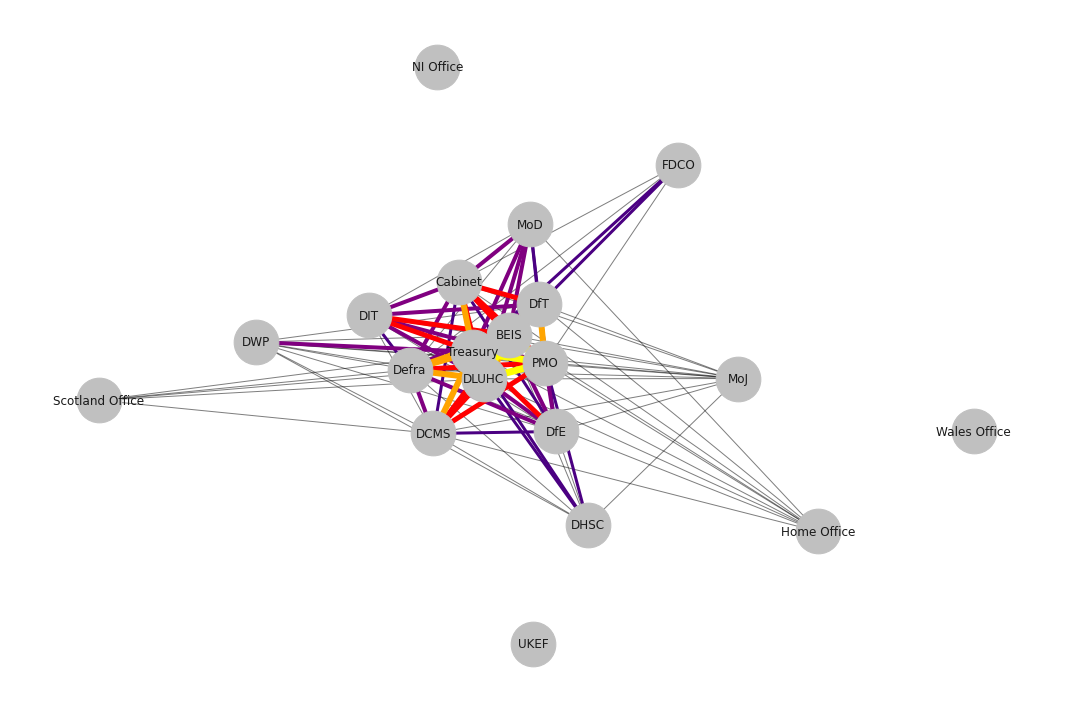

In [ ]:
#@title Force-directed network graph of Plan for Growth policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(pfg_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 100]
e_4 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 50 and d["edge"] <= 100]
e_3 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 25 and d["edge"] <= 50]
e_2 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 12 and d["edge"] <= 25]
e_1 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 6 and d["edge"] <= 12]
e_0 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 6]
e_null = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (15, 10))
# Position configuration for all nodes; seed for reproducibility
pos = nx.spring_layout(pfg_network, weight = "edge", seed = 7, k = 2.5)
# Generate nodes
nx.draw_networkx_nodes(
    pfg_network, pos, node_size = 2000, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_0, width = 1, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid"
)
# Label nodes
nx.draw_networkx_labels(
    pfg_network, pos, font_size = 12, font_family = "sans-serif"
)
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()

Graph with 20 nodes and 190 edges


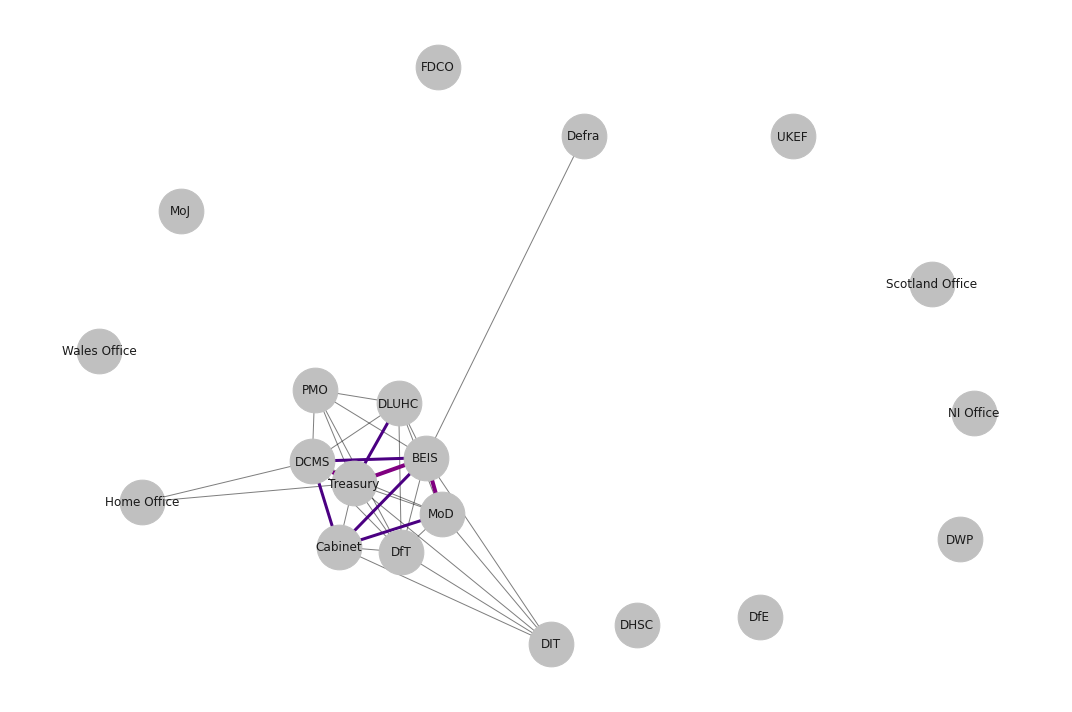

In [ ]:
#@title Force-directed network graph of UK Innovation Strategy policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(ukis_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 100]
e_4 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 50 and d["edge"] <= 100]
e_3 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 25 and d["edge"] <= 50]
e_2 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 12 and d["edge"] <= 25]
e_1 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 6 and d["edge"] <= 12]
e_0 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 6]
e_null = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (15, 10))
# Position configuration for all nodes; seed for reproducibility
pos = nx.spring_layout(ukis_network, weight = "edge", seed = 7, k = 1.2)
# Generate nodes
nx.draw_networkx_nodes(
    ukis_network, pos, node_size = 2000, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_0, width = 1, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid"
)
# Label nodes
nx.draw_networkx_labels(
    ukis_network, pos, font_size = 12, font_family = "sans-serif"
)
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()

### Network graph of policy permeation: $e_{u, v} = \sum_{t} log\left(\frac{tf_{t, u} + tf_{t, v}}{2}+1\right)$
---
Another alternative weight construction that can be explored is asas follows:

$$
e_{u, v} = \sum_{t} log\left(\frac{tf_{t, u} + tf_{t, v}}{2}+1\right)
$$

Here, the core metric for the weight of policy, $p$, is the average of $tf_{t, u}$ and $tf_{t, v}$ pair. To reduce skewing effect stemming from instances of disproportionately high $tf_{t}$ values, the log operator is applied prior to aggregation; adding one prior to the log operator allows us to deal with $tf_{t, u}$ and $tf_{t, v}$ pairs that sum to zero (i.e. $log(1) = 0$).

*N.B. Network properties will be identical as in the case of $e_{u, v} = \frac{\sum_{t} w_{t, u, v}}{n}$ where $w_{t, u, v} \in(0,1)$*


In [ ]:
#@title Undirected network graph dataframe for Plan for Growth
import numpy as np              # linear algebra

# Create placeholder dataframe
pfg_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(pfg_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with average non-zero policy pairs 
row = 0
for i in range(0, len(pfg_ministries.columns) - 1):
    for j in range(i, len(pfg_ministries.columns) - 1):
        if i != j:
            pfg_ministries_net.dept1[row] = pfg_ministries.columns[i]
            pfg_ministries_net.dept2[row] = pfg_ministries.columns[j]
            for k in range(0, len(pfg_ministries.index)):
                if pfg_ministries.iloc[k, i] != 0 and pfg_ministries.iloc[k, j] != 0:
                    pfg_ministries_net.edge[row] += (
                        (pfg_ministries.iloc[k, i] + pfg_ministries.iloc[k, j]) / 2
                    )
            row += 1

pfg_ministries_net["edge"] = np.log(pfg_ministries_net["edge"] + 1)


# Remove edges with value 0 and sort dataframe by weighted edges
pfg_ministries_net = pfg_ministries_net.sort_values(
    "edge", ascending = False
)
pfg_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    pfg_ministries_net = pfg_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title Undirected network graph dataframe for UK Innovation Strategy
# Create placeholder dataframe
ukis_ministries_net = pd.DataFrame(
    0, index = range(
        0, triangular_number(len(ukis_ministries.columns) - 2)
    ),
    columns = ["dept1", "dept2", "edge"]
)


# Populating dataframe with average non-zero policy pairs 
row = 0
for i in range(0, len(ukis_ministries.columns) - 1):
    for j in range(i, len(ukis_ministries.columns) - 1):
        if i != j:
            ukis_ministries_net.dept1[row] = ukis_ministries.columns[i]
            ukis_ministries_net.dept2[row] = ukis_ministries.columns[j]
            for k in range(0, len(ukis_ministries.index)):
                if ukis_ministries.iloc[k, i] != 0 and ukis_ministries.iloc[k, j] != 0:
                    ukis_ministries_net.edge[row] += (
                        (ukis_ministries.iloc[k, i] + ukis_ministries.iloc[k, j]) / 2
                    )
            row += 1

ukis_ministries_net["edge"] = np.log(ukis_ministries_net["edge"] + 1)


# Remove edges with value 0 and sort dataframe by weighted edges
ukis_ministries_net = ukis_ministries_net.sort_values(
    "edge", ascending = False
)
ukis_ministries_net.reset_index(drop = True, inplace = True)


# Shortening/abbreviating minsitry names
abbr = [
        "Cabinet", "BEIS", "DCMS", "DfE", "Defra", "DIT", "DLUHC", "DfT",
        "DWP", "DHSC", "FDCO", "Treasury", "Home Office", "MoD", "MoJ", "NIO",
        "Scotland Office", "Wales Office", "PMO", "UKEF"
]

for i in range(0, len(abbr)):
    ukis_ministries_net = ukis_ministries_net.replace(
        ministries_list[i], abbr[i], regex = True
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Graph with 20 nodes and 190 edges


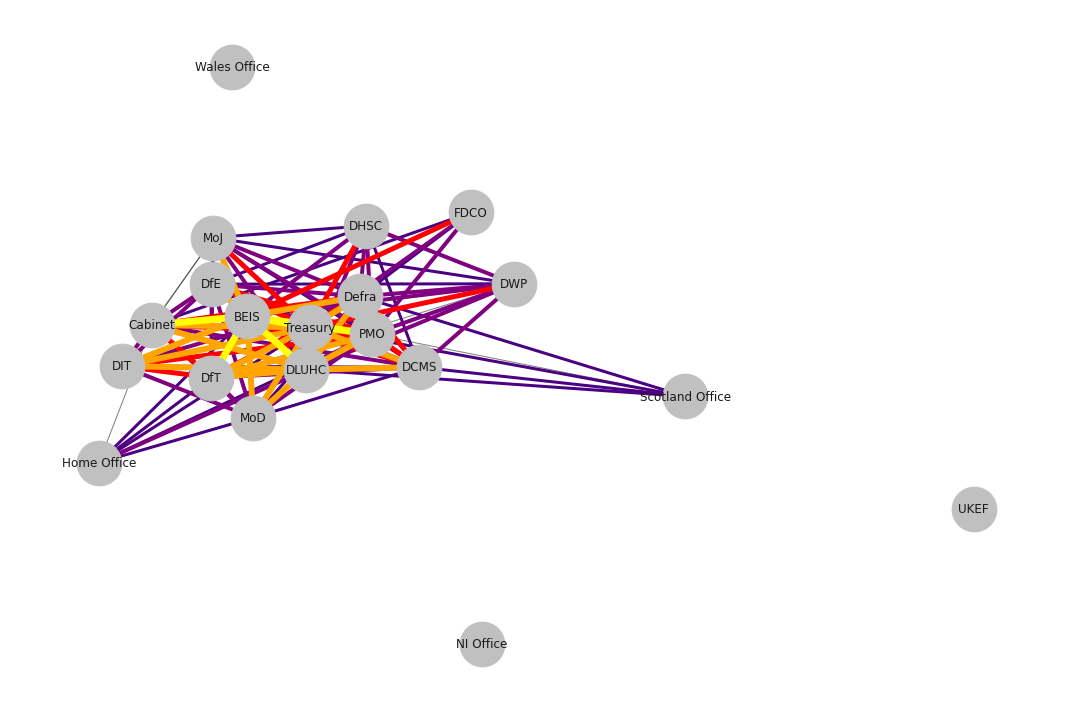

In [ ]:
#@title Force-directed network graph of Plan for Growth policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
pfg_network = nx.from_pandas_edgelist(
    pfg_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(pfg_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 6.5]
e_4 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 5 and d["edge"] <= 6.5]
e_3 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 3.5 and d["edge"] <= 5]
e_2 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 2 and d["edge"] <= 3.5]
e_1 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 1 and d["edge"] <= 2]
e_0 = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 1]
e_null = [(u, v) for (u, v, d) in pfg_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (15, 10))
# Position configuration for all nodes; seed for reproducibility
pos = nx.spring_layout(pfg_network, weight = "edge", seed = 7, k = 1.2)
# Generate nodes
nx.draw_networkx_nodes(
    pfg_network, pos, node_size = 2000, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_0, width = 1, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid"
)
nx.draw_networkx_edges(
    pfg_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid"
)
# Label nodes
nx.draw_networkx_labels(
    pfg_network, pos, font_size = 12, font_family = "sans-serif"
)
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()

Graph with 20 nodes and 190 edges


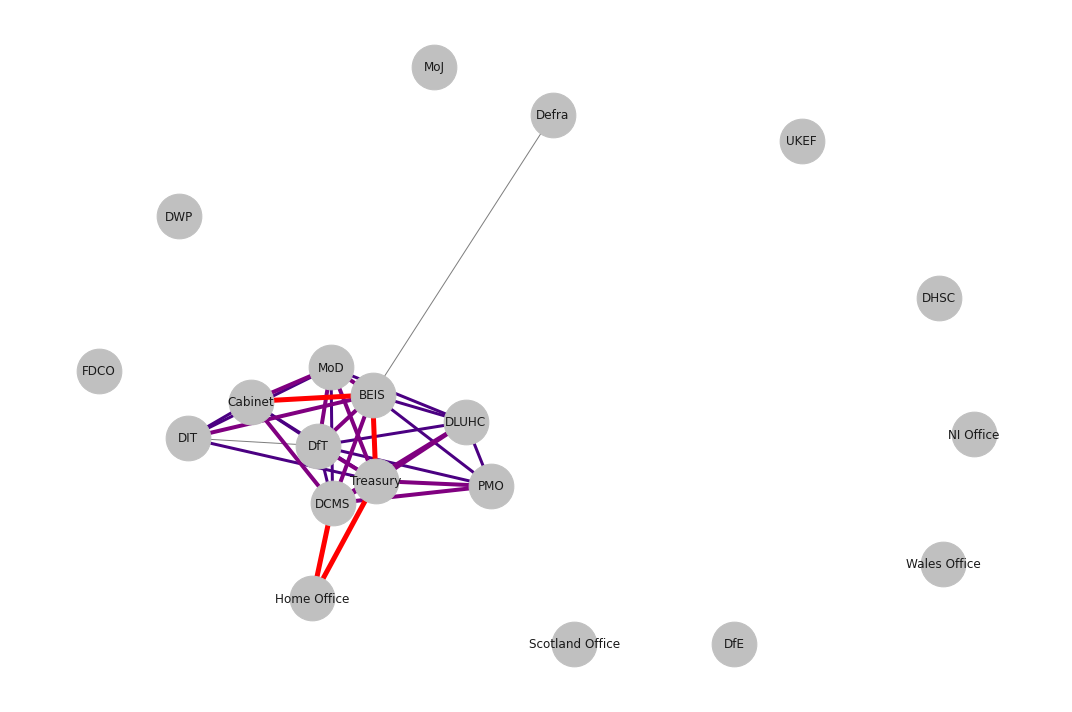

In [ ]:
#@title Force-directed network graph of UK Innovation Strategy policy linkages
import networkx as nx           # Network analysis in Python
import matplotlib.pyplot as plt
%matplotlib inline

# Convert dataframe into graph with weighted edges
ukis_network = nx.from_pandas_edgelist(
    ukis_ministries_net, source = "dept1", target = "dept2", edge_attr = "edge",
    create_using = nx.Graph()
)


# Print summary graph statistics 
print(nx.info(ukis_network))


# Partition weighted edges into 6 categories (increments of 0.1)
e_5 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 6.5]
e_4 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 5 and d["edge"] <= 6.5]
e_3 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 3.5 and d["edge"] <= 5]
e_2 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 2 and d["edge"] <= 3.5]
e_1 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 1 and d["edge"] <= 2]
e_0 = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] > 0 and d["edge"] <= 1]
e_null = [(u, v) for (u, v, d) in ukis_network.edges(data=True) if d["edge"] == 0]


# Set the width and height of the figure
plt.figure(figsize = (15, 10))
# Position configuration for all nodes; seed for reproducibility
pos = nx.spring_layout(ukis_network, weight = "edge", seed = 7, k = 1)
# Generate nodes
nx.draw_networkx_nodes(
    ukis_network, pos, node_size = 2000, node_color = "silver"
)
# Generate edges
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_null, width = 1, alpha = 0,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_0, width = 1, alpha = 0.5,
    edge_color = "black", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_1, width = 3, alpha = 1,
    edge_color = "indigo", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_2, width = 4, alpha = 1,
    edge_color = "purple", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_3, width = 5, alpha = 1,
    edge_color = "red", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_4, width = 6, alpha = 1,
    edge_color = "orange", style = "solid"
)
nx.draw_networkx_edges(
    ukis_network, pos, edgelist = e_5, width = 7, alpha = 1,
    edge_color = "yellow", style = "solid"
)
# Label nodes
nx.draw_networkx_labels(
    ukis_network, pos, font_size = 12, font_family = "sans-serif"
)
# Plot configuration
plt.axis("off")
plt.tight_layout()
plt.show()

## ***N*-gram plots**
---
As a validation exercise of our dictionary of search terms, we check instances in which the tokens matches with one of the trigger phrases, and then takes in a set number of tokens preceding and after these tokens to capture the content of interest.

We first create *n*-grams for these "policy-centred" tokens; that is, the contiguous sequence of *n* items surrounding the search term token of interest. These *n*-grams are then through a word frequency counter that tallies their count to obtain the most common sub-phrases mentioned in his speeches.

The [`sklearn`](https://scikit-learn.org) package is used here to compute the term frequencies, using a function called [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [ ]:
#@title Compile list of tokens containing relevant policy terms
#@markdown *Last execution speed: 40m 23s*
import re                       # regular expression operations
import time
start_time = time.time()

# Create policy-centred tokens
doc_df["policy-centred token"] = ""
for i in range(0, len(doc_df)):
    for j in range(0, len(search_terms)):
        temp = " ".join(re.findall(
            '.{40}' + re.escape(search_terms[j]) + '.{40}',
            doc_df["text"][i]
        ))
        doc_df["policy-centred token"][i] = (
            doc_df["policy-centred token"][i] + " " + temp
        )
        # remove excess whitespaces
        doc_df["policy-centred token"][i] = re.sub(
            " +", " ", doc_df["policy-centred token"][i]
        )

# Execution speed
elapsed_time = time.time() - start_time
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:40:23


In [ ]:
#@title Tokenisation and stop words removal
import nltk                     # language processing operations
nltk.download("punkt")
nltk.download("stopwords")

# # Tokenise speech words
# d2 = {}
# for i in range(0, len(speech)):
#     d2[speech[i]] = word_tokenize(d1[speech[i]])


# Stop words
stopwords = nltk.corpus.stopwords.words("english")

# for i in range(0, len(speech)):
#     d2[speech[i]] = [word for word in d2[speech[i]] if word not in stopwords]
#     d2[speech[i]] = " ".join(d2[speech[i]])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#@title Convert policy-centred tokens into a matrix of token counts
import numpy as np              # linear algebra
from sklearn.feature_extraction.text import CountVectorizer

# Create dataframe for 4-gram
vectoriser = CountVectorizer(
    stop_words = stopwords, ngram_range = (6, 6), max_features = 300
)
ngram_df = (
    pd.DataFrame(
        vectoriser.fit_transform(doc_df["policy-centred token"]).toarray(),
        columns = vectoriser.get_feature_names(),
    )
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



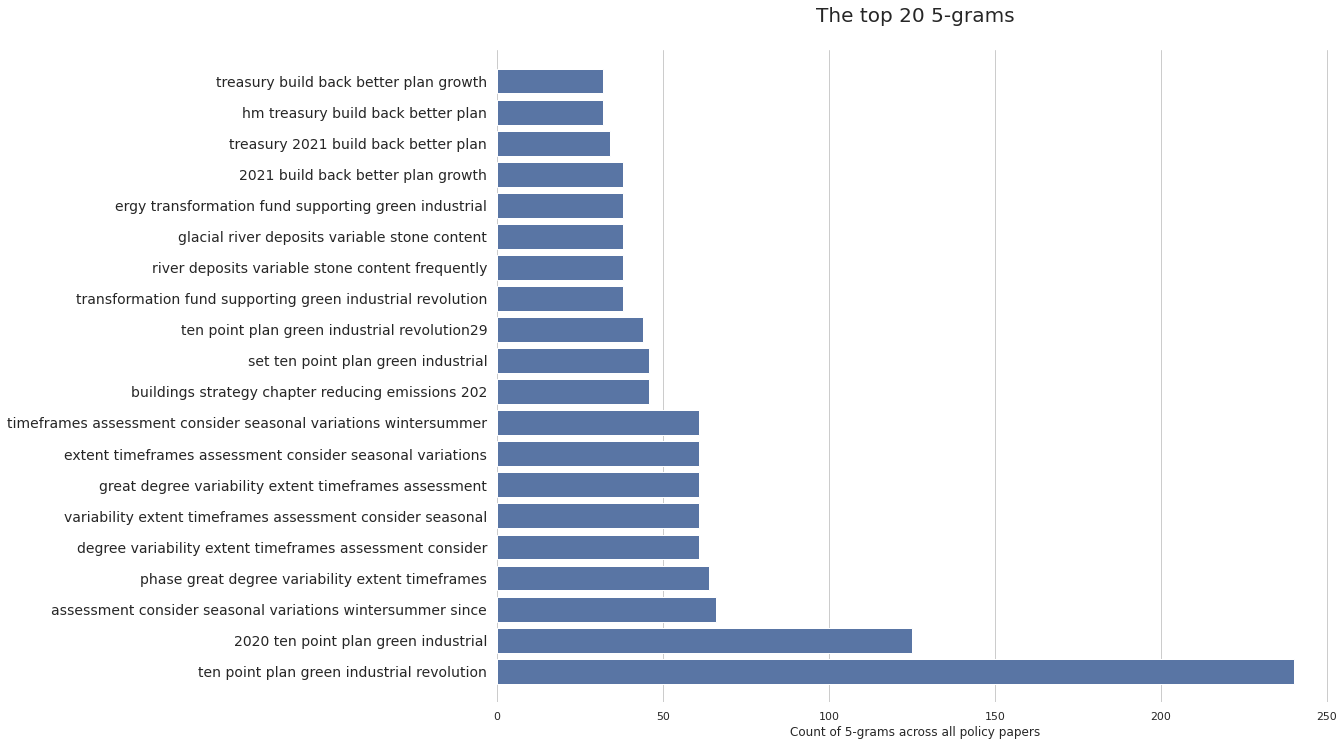

In [ ]:
#@title N-gram plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialise matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style = "whitegrid")
sns.barplot(
    x = ngram_df[:num].values,
    y = ngram_df[:num].index,
    color = "b"
)
ax.set_yticklabels(ngram_df[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of 5-grams across all policy papers")
ax.set_title(f"The top {num} 5-grams\n", fontsize = 20)
sns.despine(left = True, bottom = True)

## **Term frequency-inverse document frequency (tf-idf)**
---
Term frequency-inverse document frequency (often referred to as *tf-idf*), is an alternative measure of term counts that is weighted to try and identify the most *distinctively* frequent terms in a given corpus. This type of count can be applied on any *n*-grams, (unigrams, bigrams, etc.).

*Tf-idf* has two parts:
* the term-frequency (denoted below as $t$), which upweights according to counts of terms), and
* an inverse document frequency (denoted below as $s$), which downweights terms that appear frequently across the corpus.

In this analysis, $t$ represents words while policy papers are the rows from the `doc_df` dataframe. The formula for term frequency is:

$$
{\displaystyle \mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}}
$$

where $f_{t,d}$ represents the frequency of term $t$ in document $d$.The [`sklearn`](https://scikit-learn.org) package is once again used here to compute each term's *tf-idf* score, using a function called [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [ ]:
#@title Convert policy-centred tokens into a matrix of tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Create dataframe for 4-gram tf-idf scores
tfidf_vectoriser = TfidfVectorizer(
    ngram_range = (4, 4), sublinear_tf = True
)
X = tfidf_vectoriser.fit_transform(doc_df["policy-centred token"])
fourgram_tfidf = (
    pd.DataFrame(X.toarray(), columns = tfidf_vectoriser.get_feature_names())
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



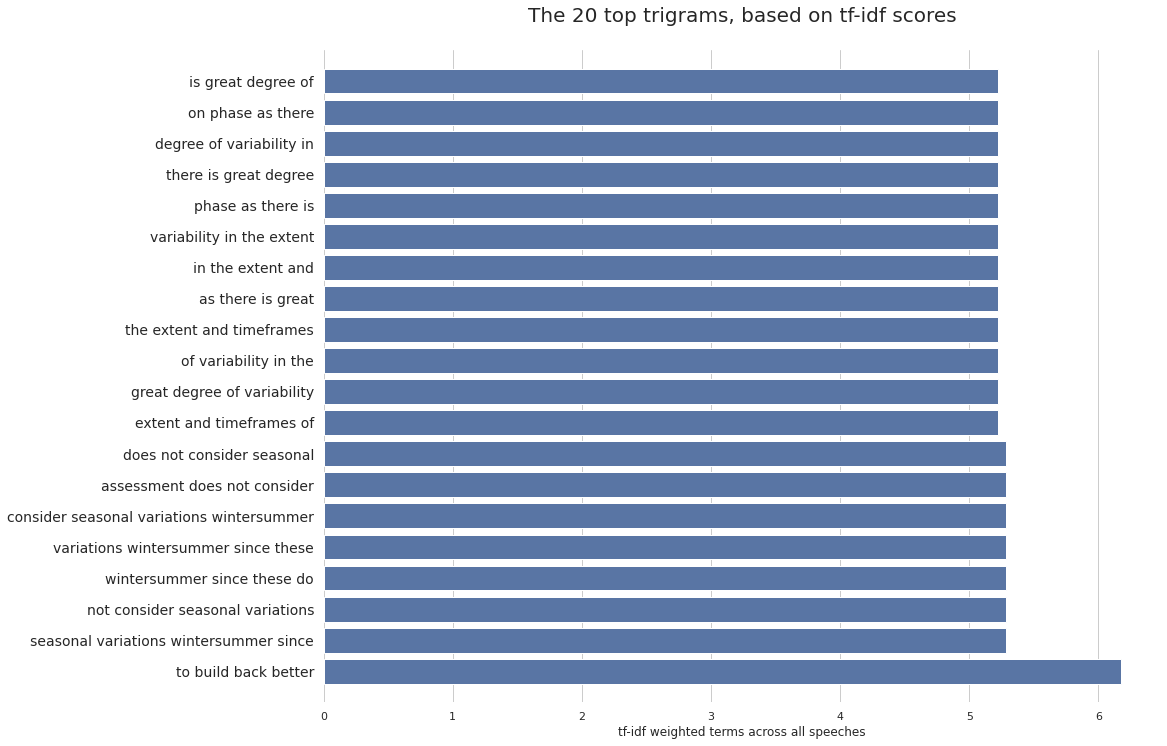

In [ ]:
#@title 4-gram tf-idf plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style = "whitegrid")
sns.barplot(
    x = fourgram_tfidf[:num].values,
    y = fourgram_tfidf[:num].index,
    color = "b"
)
ax.set_yticklabels(fourgram_tfidf[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("tf-idf weighted terms across all speeches")
ax.set_title(f"The {num} top trigrams, based on tf-idf scores\n", fontsize = 20)
sns.despine(left = True, bottom = True)